# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import h5py
import scipy
from scipy import stats
from scipy.stats import bootstrap
import h5py

#Sklearn
import sklearn
import sklearn.metrics

#Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import AutoMinorLocator
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [154]:
colors = ['#ffc71f','#58D68D',
          '#3498DB','#9B59B6','#D4357A']

In [3]:
h = 0.68

# Read in Train, Validation, and Test Data

In [4]:
#Routine for extracting information from the commented header lines
def find_in_header(filename, header):
    with open(filename, "r") as f:
        for line in f:
            if line[0:(len(header))]==header:
                return(line[len(header):].split())


BP_file = 'BP.out' #Neighbor files output by "find_neighbors" program (added to UniverseMachine)
SMDPL_file = 'SMDPL.out'

column_labels = find_in_header(BP_file,'#Header:')

#Record the positions of each section
neighbors = np.arange(0,51,1)

column_indices = {}
loc_ID = []
loc_X = []
loc_Y = []
loc_HM = []
loc_SM = []
loc_Dist = []
loc_Cyl = []
loc_Z = []
for x in range(len(column_labels)):
    if "Halo_ID" in column_labels[x]:
        loc_ID.append(x)
    elif "Halo_Mass" in column_labels[x]:
        loc_HM.append(x)
    elif "Stellar_Mass" in column_labels[x]:
        loc_SM.append(x)
    elif "Distance" in column_labels[x]:
        loc_Dist.append(x)
    elif "Cylinder" in column_labels[x]:
        loc_Cyl.append(x)
    elif "X" in column_labels[x]:
        loc_X.append(x)
    elif "Y" in column_labels[x]:
        loc_Y.append(x)
    elif "Z_Diff" in column_labels[x]:
        loc_Z.append(x)

column_indices['ID'] = loc_ID
column_indices['X'] = loc_X
column_indices['Y'] = loc_Y
column_indices['HM'] = loc_HM
column_indices['SM'] = loc_SM
column_indices['Dist'] = loc_Dist
column_indices['Cylinder'] = loc_Cyl
column_indices['Z'] = loc_Z

BP = pd.read_csv(BP_file, sep='\s+', comment='#', names=column_labels,low_memory=False)
SMDPL = pd.read_csv(SMDPL_file, sep='\s+', comment='#', names=column_labels,low_memory=False)

In [5]:
dtype = np.dtype(dtype=[('id', 'i8'),('descid','i8'),('upid','i8'),
                        ('flags', 'i4'), ('uparent_dist', 'f4'),
                        ('pos', 'f4', (6)), ('vmp', 'f4'), ('lvmp', 'f4'),
                        ('mp', 'f4'), ('m', 'f4'), ('v', 'f4'), ('r', 'f4'),
                        ('rank1', 'f4'), ('rank2', 'f4'), ('ra', 'f4'),
                        ('rarank', 'f4'), ('A_UV', 'f4'), ('sm', 'f4'),
                        ('icl', 'f4'), ('sfr', 'f4'), ('obs_sm', 'f4'),
                        ('obs_sfr', 'f4'), ('obs_uv', 'f4'), ('empty', 'f4')],
                 align=True)

Run the next four cells if this is the first time through

In [6]:
SMDPL2 = np.fromfile('UniverseMachine/sfr_catalog_1.000000.bin',dtype)

#Put data in Pandas Dataframe
SMDPL_df = pd.DataFrame({
    'ID':SMDPL2['id'],
    'UPID':SMDPL2['upid'],
    'Flag':SMDPL2['flags'],
    'HM':SMDPL2['mp'],
    'SM':SMDPL2['obs_sm']
})

ignore_flags=[16,17,18,20,24,48]
SMDPL_df = SMDPL_df[~SMDPL_df['Flag'].isin(ignore_flags)]

In [6]:
BP2 = np.fromfile('UniverseMachine/sfr_catalog_1.002310.bin',dtype)

#Put data in Pandas Dataframe
BP_df = pd.DataFrame({
    'ID':BP2['id'],
    'UPID':BP2['upid'],
    'Flag':BP2['flags'],
    'HM':BP2['mp'],
    'SM':BP2['obs_sm']
})

ignore_flags=[16,17,18,20,24,48]
BP_df = BP_df[~BP_df['Flag'].isin(ignore_flags)]

In [8]:
#Merge with SMDPL_df to know which are satellites vs. centrals
SMDPL_combo = SMDPL.merge(SMDPL_df,left_on='Halo_ID(0)',right_on='ID',how='left')

#Convert Stellar Masses to cumulative number densities
V_SMDPL = 400**3
Ranks = SMDPL['Stellar_Mass(0)'].rank(ascending=False,method='average')/V_SMDPL

SM_dict = {k:v for k,v in zip(SMDPL['Stellar_Mass(0)'],Ranks)}

def get_rank(x):
    y = SM_dict[x]
    return y

SMDPL2 = SMDPL_combo.copy()
keys = SMDPL2.filter(like='Stellar_Mass').columns
for k in keys:
    SMDPL2[k] = SMDPL2[k].apply(get_rank)

In [7]:
BP_combo = BP.merge(BP_df,left_on='Halo_ID(0)',right_on='ID',how='left')

V_BP = 250**3
Ranks2 = BP['Stellar_Mass(0)'].rank(ascending=False,method='average')/V_BP

SM_dict2 = {k:v for k,v in zip(BP['Stellar_Mass(0)'],Ranks2)}

def get_rank(x):
    y = SM_dict2[x]
    return y

BP2 = BP_combo.copy()
keys = BP2.filter(like='Stellar_Mass').columns
for k in keys:
    BP2[k] = BP2[k].apply(get_rank)

# Preprocess Train and Validation Data

Scale values to have mean $=0$, std $=1$. Use log scale for masses and linear for rest

In [ ]:
#Uncomment the two lines below and run them if you are loading a preprocessed version of the data
#SMDPL2.to_hdf('SMDPL_preprocessed.h5', key='halos', mode='w') 
#SMDPL2 = pd.read_hdf('SMDPL_preprocessed.h5', 'halos')  

In [10]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()
scaler5 = StandardScaler()

halos_scaled = SMDPL2.copy()

halos_scaled['Halo_Mass'] = scaler1.fit_transform(np.array(np.log10(SMDPL2['Halo_Mass'])).reshape(-1,1))
halos_scaled.iloc[:,column_indices['SM']] = scaler2.fit_transform(np.log10(SMDPL2.iloc[:,column_indices['SM']]))
halos_scaled.iloc[:,column_indices['Dist']] = scaler3.fit_transform(SMDPL2.iloc[:,column_indices['Dist']])
halos_scaled.iloc[:,column_indices['Cylinder']] = scaler4.fit_transform(SMDPL2.iloc[:,column_indices['Cylinder']])
halos_scaled.iloc[:,column_indices['Z']] = scaler5.fit_transform(SMDPL2.iloc[:,column_indices['Z']])

In [ ]:
#Uncomment the two lines below and run them if you are loading a preprocessed version of the data
#BP2.to_hdf('BP_preprocessed.h5', key='halos', mode='w') 
#BP2 = pd.read_hdf('BP_preprocessed.h5', 'halos')  

In [8]:
scaler1t = StandardScaler()
scaler2t = StandardScaler()
scaler3t = StandardScaler()
scaler4t = StandardScaler()
scaler5t = StandardScaler()

test_scaled = BP2.copy()

test_scaled['Halo_Mass'] = scaler1t.fit_transform(np.array(np.log10(BP2['Halo_Mass'])).reshape(-1,1))
test_scaled.iloc[:,column_indices['SM']] = scaler2t.fit_transform(np.log10(BP2.iloc[:,column_indices['SM']]))
test_scaled.iloc[:,column_indices['Dist']] = scaler3t.fit_transform(BP2.iloc[:,column_indices['Dist']])
test_scaled.iloc[:,column_indices['Cylinder']] = scaler4t.fit_transform(BP2.iloc[:,column_indices['Cylinder']])
test_scaled.iloc[:,column_indices['Z']] = scaler5t.fit_transform(BP2.iloc[:,column_indices['Z']])

In [12]:
#Split SMDPL in training and validation data based on X-pos of galaxies (put 70% of volume in training)

train = halos_scaled[halos_scaled['X']<=400*0.7]
val = halos_scaled[halos_scaled['X']>400*0.7]

In [13]:
print(len(train),len(val))

2048724 828945


# Select Features to Train Model

In [9]:
def get_knn_features1(k):
    #No redshift info
    feature_list = ['Stellar_Mass(0)']
    for i in np.arange(1,k+1):
        feature_list.append('Stellar_Mass('+str(i)+')')
        feature_list.append('Distance('+str(i)+')')
    return feature_list

In [10]:
def get_knn_features2(k):
    #Yes redshift info
    feature_list = ['Stellar_Mass(0)']
    for i in np.arange(1,k+1):
        feature_list.append('Stellar_Mass('+str(i)+')')
        feature_list.append('Distance('+str(i)+')')
        feature_list.append('Z_Diff('+str(i)+')')
    return feature_list

In [ ]:
y_train = tf.convert_to_tensor(train['Halo_Mass'])
y_val = tf.convert_to_tensor(val['Halo_Mass'])

In [17]:
#Preprocessing -> get weights
#This function is to weight halos by number density in halo mass

def get_weights(masses):
    bins = 25
    hmf,mhalo = np.histogram(masses,bins=bins)
    mhalo = 0.5*(mhalo[0:-1]+mhalo[1:])
    p_x = np.interp(np.float64(masses), np.float64(mhalo), hmf)
    A = p_x.mean()
    weights = np.sqrt(A/p_x)
    return weights

w_train = tf.convert_to_tensor(get_weights(train['Halo_Mass']))
w_val = tf.convert_to_tensor(get_weights(val['Halo_Mass']))

In [12]:
feature_list_knn50_v1 = get_knn_features1(50)
feature_list_knn50_v2 = get_knn_features2(50)
combo_feature_list = np.concatenate([np.array(feature_list_knn50_v1),
                                    np.array(test_scaled.filter(like='Cylinder').columns)])

In [18]:
feature_list_knn50_v1 = get_knn_features1(50)
X_train_knn50_v1 = tf.convert_to_tensor(train[feature_list_knn50_v1])
X_val_knn50_v1 = tf.convert_to_tensor(val[feature_list_knn50_v1])

2023-06-05 16:20:24.100284: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1655368992 exceeds 10% of free system memory.


In [19]:
feature_list_knn50_v2 = get_knn_features2(50)
X_train_knn50_v2 = tf.convert_to_tensor(train[feature_list_knn50_v2])
X_val_knn50_v2 = tf.convert_to_tensor(val[feature_list_knn50_v2])

2023-06-05 16:20:28.438815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2474858592 exceeds 10% of free system memory.
2023-06-05 16:20:30.853831: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1001365560 exceeds 10% of free system memory.


In [20]:
X_train_cyl = train[train.filter(like='Cylinder').columns]
X_train_cyl['Stellar Mass'] = train['Stellar_Mass(0)']

X_val_cyl = val[val.filter(like='Cylinder').columns]
X_val_cyl['Stellar Mass'] = val['Stellar_Mass(0)']

In [21]:
combo_feature_list = np.concatenate([np.array(feature_list_knn50_v1),
                                    np.array(train.filter(like='Cylinder').columns)])
X_train_combo = train[combo_feature_list]
X_val_combo = val[combo_feature_list]

# Initialize Models

In [22]:
lr = 0.001
activation_fnc = 'relu'
loss_fnc = 'mean_absolute_error'
n_layers = 4
factor = 0.8
batch_size = 128

In [23]:
#Define and compile dense model

def create_dense_model(shape,layers,lr,activation_fnc,loss_fnc,use_weights):

    model = keras.models.Sequential()
    model.add(keras.Input(shape=shape))
    for i in range(len(layers)):
        model.add(keras.layers.Dense(layers[i], activation=activation_fnc))
    model.add(keras.layers.Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)

    if use_weights == 1: #make weighted model
        model.compile(optimizer=adam,
                      loss=loss_fnc,
                      metrics = [
                          metrics.MeanSquaredError(),
                          metrics.MeanAbsoluteError()
                      ],
                      weighted_metrics = [
                          metrics.MeanSquaredError(),
                          metrics.MeanAbsoluteError()])
    else: #make unweighted model
        model.compile(optimizer=adam,
                      loss=loss_fnc,
                      metrics = [
                          metrics.MeanSquaredError(),
                          metrics.MeanAbsoluteError()
                      ])

    return model

# Train Models

In [24]:
#Call this function to train a model (must be pre-compiled)

def train_model(model_name,shape,n_layers,factor,
                lr,activation_fnc,loss_fnc,
                X_train,X_val,y_train,y_val,
                w_train,w_val,use_weights,batch_size,
                epochs,patience):
    
    print(model_name)
    
    layers = []
    x = shape[0]
    layers.append(x)
    for j in range(n_layers):
        x = int(x*factor)
        layers.append(x)
        
    model = create_dense_model(shape,layers,lr,activation_fnc,loss_fnc,use_weights)
    
    if use_weights==0:
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('Models/weights_'+model_name+'.h5',
                                                            save_best_only=True)
        early_stopping_cb     = tf.keras.callbacks.EarlyStopping(monitor='val_loss',start_from_epoch=10, 
                                                          patience=patience,restore_best_weights=True)
        history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,
                      validation_data=(X_val,y_val),verbose=2,callbacks=[checkpoint_cb,early_stopping_cb])
    
    
    else:
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('Models/weights_'+model_name+'.h5',
                                                            save_best_only=True)
        early_stopping_cb     = tf.keras.callbacks.EarlyStopping(monitor='val_loss',start_from_epoch=10,
                                                          patience=patience,restore_best_weights=True)
        history = model.fit(X_train,y_train,sample_weight=w_train,epochs=epochs,batch_size=batch_size,
                      validation_data=(X_val,y_val,w_val),verbose=2,callbacks=[checkpoint_cb,early_stopping_cb])
        
    #Save fitting history
    hf = h5py.File('Models/history_'+model_name+'.h5', 'x')
    for item in history.history:
        data = np.array(history.history[item])
        hf.create_dataset(item, data=data)
    hf.close()

    model.save('Models/net_'+model_name+'_trained.h5') #Save trained model to file
    
    return model,history

## Default Models:
1. 51 stellar masses + 50 distances
2. 51 stellar masses + 50 distances + 50 z-separations
3. 1 stellar mass + 32 counts in bins
4. 51 stellar masses + 50 distances + 32 counts in bins

In [25]:
use_weights = 0 #unweighted
model_knn_u,history_knn_u = train_model("knn50_u",(101,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_v1,X_val_knn50_v1,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_knn_uz,history_knn_uz = train_model("knn50_uz",(151,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_v2,X_val_knn50_v2,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_cyl_u,history_cyl_u = train_model("cyl_u",(33,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_cyl,X_val_cyl,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_combo_u,history_combo_u = train_model("combo_u",(133,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_combo,X_val_combo,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)


use_weights = 1 #weighted
model_knn_w,history_knn_w = train_model("knn50_w",(101,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_v1,X_val_knn50_v1,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_knn_wz,history_knn_wz = train_model("knn50_wz",(151,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_v2,X_val_knn50_v2,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_cyl_w,history_cyl_w = train_model("cyl_w",(33,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_cyl,X_val_cyl,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

model_combo_w,history_combo_w = train_model("combo_w",(133,),n_layers,factor,lr,
                                        activation_fnc,loss_fnc,
                                        X_train_combo,X_val_combo,
                                        y_train,y_val,
                                        w_train,w_val,
                                        use_weights,batch_size,
                                        epochs=50,patience=10)

#

knn50_u
Epoch 1/50
16006/16006 - 23s - loss: 0.3064 - mean_squared_error: 0.1777 - mean_absolute_error: 0.3064 - val_loss: 0.3009 - val_mean_squared_error: 0.1694 - val_mean_absolute_error: 0.3009 - 23s/epoch - 1ms/step
Epoch 2/50
16006/16006 - 22s - loss: 0.2984 - mean_squared_error: 0.1691 - mean_absolute_error: 0.2984 - val_loss: 0.2963 - val_mean_squared_error: 0.1685 - val_mean_absolute_error: 0.2963 - 22s/epoch - 1ms/step
Epoch 3/50
16006/16006 - 22s - loss: 0.2968 - mean_squared_error: 0.1675 - mean_absolute_error: 0.2968 - val_loss: 0.2958 - val_mean_squared_error: 0.1675 - val_mean_absolute_error: 0.2958 - 22s/epoch - 1ms/step
Epoch 4/50
16006/16006 - 22s - loss: 0.2958 - mean_squared_error: 0.1666 - mean_absolute_error: 0.2958 - val_loss: 0.2950 - val_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.2950 - 22s/epoch - 1ms/step
Epoch 5/50
16006/16006 - 23s - loss: 0.2953 - mean_squared_error: 0.1660 - mean_absolute_error: 0.2953 - val_loss: 0.2939 - val_mean_squared_err

Epoch 10/50
16006/16006 - 31s - loss: 0.2911 - mean_squared_error: 0.1618 - mean_absolute_error: 0.2911 - val_loss: 0.2920 - val_mean_squared_error: 0.1628 - val_mean_absolute_error: 0.2920 - 31s/epoch - 2ms/step
Epoch 11/50
16006/16006 - 30s - loss: 0.2908 - mean_squared_error: 0.1615 - mean_absolute_error: 0.2908 - val_loss: 0.2920 - val_mean_squared_error: 0.1630 - val_mean_absolute_error: 0.2920 - 30s/epoch - 2ms/step
Epoch 12/50
16006/16006 - 30s - loss: 0.2905 - mean_squared_error: 0.1612 - mean_absolute_error: 0.2905 - val_loss: 0.2935 - val_mean_squared_error: 0.1656 - val_mean_absolute_error: 0.2935 - 30s/epoch - 2ms/step
Epoch 13/50
16006/16006 - 30s - loss: 0.2902 - mean_squared_error: 0.1611 - mean_absolute_error: 0.2902 - val_loss: 0.2916 - val_mean_squared_error: 0.1624 - val_mean_absolute_error: 0.2916 - 30s/epoch - 2ms/step
Epoch 14/50
16006/16006 - 29s - loss: 0.2901 - mean_squared_error: 0.1609 - mean_absolute_error: 0.2901 - val_loss: 0.2916 - val_mean_squared_error:

Epoch 16/50
16006/16006 - 11s - loss: 0.3019 - mean_squared_error: 0.1728 - mean_absolute_error: 0.3019 - val_loss: 0.3009 - val_mean_squared_error: 0.1721 - val_mean_absolute_error: 0.3009 - 11s/epoch - 692us/step
Epoch 17/50
16006/16006 - 11s - loss: 0.3019 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3019 - val_loss: 0.3006 - val_mean_squared_error: 0.1713 - val_mean_absolute_error: 0.3006 - 11s/epoch - 688us/step
Epoch 18/50
16006/16006 - 10s - loss: 0.3018 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3018 - val_loss: 0.3010 - val_mean_squared_error: 0.1718 - val_mean_absolute_error: 0.3010 - 10s/epoch - 649us/step
Epoch 19/50
16006/16006 - 10s - loss: 0.3018 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3018 - val_loss: 0.3004 - val_mean_squared_error: 0.1710 - val_mean_absolute_error: 0.3004 - 10s/epoch - 643us/step
Epoch 20/50
16006/16006 - 10s - loss: 0.3018 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3018 - val_loss: 0.3017 - val_mean_square

2023-06-05 16:56:32.976587: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2179842336 exceeds 10% of free system memory.
2023-06-05 16:56:57.572985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 881997480 exceeds 10% of free system memory.


16006/16006 - 27s - loss: 0.3058 - mean_squared_error: 0.1767 - mean_absolute_error: 0.3058 - val_loss: 0.2986 - val_mean_squared_error: 0.1684 - val_mean_absolute_error: 0.2986 - 27s/epoch - 2ms/step
Epoch 2/50
16006/16006 - 29s - loss: 0.2974 - mean_squared_error: 0.1675 - mean_absolute_error: 0.2974 - val_loss: 0.2965 - val_mean_squared_error: 0.1689 - val_mean_absolute_error: 0.2965 - 29s/epoch - 2ms/step
Epoch 3/50
16006/16006 - 27s - loss: 0.2956 - mean_squared_error: 0.1658 - mean_absolute_error: 0.2956 - val_loss: 0.2955 - val_mean_squared_error: 0.1665 - val_mean_absolute_error: 0.2955 - 27s/epoch - 2ms/step
Epoch 4/50
16006/16006 - 29s - loss: 0.2946 - mean_squared_error: 0.1648 - mean_absolute_error: 0.2946 - val_loss: 0.2924 - val_mean_squared_error: 0.1635 - val_mean_absolute_error: 0.2924 - 29s/epoch - 2ms/step
Epoch 5/50
16006/16006 - 27s - loss: 0.2939 - mean_squared_error: 0.1642 - mean_absolute_error: 0.2939 - val_loss: 0.2978 - val_mean_squared_error: 0.1678 - val_me

Epoch 5/50
16006/16006 - 25s - loss: 0.4841 - mean_squared_error: 0.1792 - mean_absolute_error: 0.3100 - weighted_mean_squared_error: 0.2749 - weighted_mean_absolute_error: 0.3766 - val_loss: 0.4835 - val_mean_squared_error: 0.1820 - val_mean_absolute_error: 0.3134 - val_weighted_mean_squared_error: 0.2737 - val_weighted_mean_absolute_error: 0.3759 - 25s/epoch - 2ms/step
Epoch 6/50
16006/16006 - 26s - loss: 0.4823 - mean_squared_error: 0.1784 - mean_absolute_error: 0.3094 - weighted_mean_squared_error: 0.2731 - weighted_mean_absolute_error: 0.3752 - val_loss: 0.4825 - val_mean_squared_error: 0.1789 - val_mean_absolute_error: 0.3085 - val_weighted_mean_squared_error: 0.2755 - val_weighted_mean_absolute_error: 0.3751 - 26s/epoch - 2ms/step
Epoch 7/50
16006/16006 - 26s - loss: 0.4810 - mean_squared_error: 0.1780 - mean_absolute_error: 0.3088 - weighted_mean_squared_error: 0.2722 - weighted_mean_absolute_error: 0.3742 - val_loss: 0.4793 - val_mean_squared_error: 0.1704 - val_mean_absolute_

Epoch 4/50
16006/16006 - 31s - loss: 0.4828 - mean_squared_error: 0.1786 - mean_absolute_error: 0.3096 - weighted_mean_squared_error: 0.2738 - weighted_mean_absolute_error: 0.3756 - val_loss: 0.4940 - val_mean_squared_error: 0.1750 - val_mean_absolute_error: 0.3086 - val_weighted_mean_squared_error: 0.2875 - val_weighted_mean_absolute_error: 0.3841 - 31s/epoch - 2ms/step
Epoch 5/50
16006/16006 - 31s - loss: 0.4803 - mean_squared_error: 0.1776 - mean_absolute_error: 0.3086 - weighted_mean_squared_error: 0.2711 - weighted_mean_absolute_error: 0.3737 - val_loss: 0.4865 - val_mean_squared_error: 0.1698 - val_mean_absolute_error: 0.3028 - val_weighted_mean_squared_error: 0.2866 - val_weighted_mean_absolute_error: 0.3782 - 31s/epoch - 2ms/step
Epoch 6/50
16006/16006 - 31s - loss: 0.4776 - mean_squared_error: 0.1767 - mean_absolute_error: 0.3076 - weighted_mean_squared_error: 0.2683 - weighted_mean_absolute_error: 0.3715 - val_loss: 0.4794 - val_mean_squared_error: 0.1834 - val_mean_absolute_

Epoch 2/50
16006/16006 - 13s - loss: 0.5002 - mean_squared_error: 0.1897 - mean_absolute_error: 0.3193 - weighted_mean_squared_error: 0.2897 - weighted_mean_absolute_error: 0.3891 - val_loss: 0.4954 - val_mean_squared_error: 0.1871 - val_mean_absolute_error: 0.3160 - val_weighted_mean_squared_error: 0.2869 - val_weighted_mean_absolute_error: 0.3851 - 13s/epoch - 806us/step
Epoch 3/50
16006/16006 - 12s - loss: 0.4963 - mean_squared_error: 0.1882 - mean_absolute_error: 0.3179 - weighted_mean_squared_error: 0.2872 - weighted_mean_absolute_error: 0.3861 - val_loss: 0.4944 - val_mean_squared_error: 0.1865 - val_mean_absolute_error: 0.3170 - val_weighted_mean_squared_error: 0.2881 - val_weighted_mean_absolute_error: 0.3844 - 12s/epoch - 750us/step
Epoch 4/50
16006/16006 - 12s - loss: 0.4944 - mean_squared_error: 0.1874 - mean_absolute_error: 0.3171 - weighted_mean_squared_error: 0.2856 - weighted_mean_absolute_error: 0.3846 - val_loss: 0.4979 - val_mean_squared_error: 0.1841 - val_mean_absol

Epoch 24/50
16006/16006 - 11s - loss: 0.4888 - mean_squared_error: 0.1850 - mean_absolute_error: 0.3152 - weighted_mean_squared_error: 0.2802 - weighted_mean_absolute_error: 0.3802 - val_loss: 0.4889 - val_mean_squared_error: 0.1828 - val_mean_absolute_error: 0.3137 - val_weighted_mean_squared_error: 0.2822 - val_weighted_mean_absolute_error: 0.3801 - 11s/epoch - 718us/step
Epoch 25/50
16006/16006 - 11s - loss: 0.4889 - mean_squared_error: 0.1851 - mean_absolute_error: 0.3152 - weighted_mean_squared_error: 0.2799 - weighted_mean_absolute_error: 0.3803 - val_loss: 0.4909 - val_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.3170 - val_weighted_mean_squared_error: 0.2843 - val_weighted_mean_absolute_error: 0.3817 - 11s/epoch - 690us/step
combo_w
Epoch 1/50
16006/16006 - 119s - loss: 0.5135 - mean_squared_error: 0.1967 - mean_absolute_error: 0.3253 - weighted_mean_squared_error: 0.3074 - weighted_mean_absolute_error: 0.3995 - val_loss: 0.4926 - val_mean_squared_error: 0.1762 - val

Epoch 21/50
16006/16006 - 29s - loss: 0.4669 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3049 - weighted_mean_squared_error: 0.2572 - weighted_mean_absolute_error: 0.3632 - val_loss: 0.4766 - val_mean_squared_error: 0.1689 - val_mean_absolute_error: 0.3013 - val_weighted_mean_squared_error: 0.2759 - val_weighted_mean_absolute_error: 0.3706 - 29s/epoch - 2ms/step


In [1]:
#Uncomment lines below to load a set of pre-trained models (make sure to change run_6_5 to the path of your models)

#model_knn_u = tf.keras.models.load_model('Models/run_6_5/net_knn50_u_trained.h5')
#model_knn_w = tf.keras.models.load_model('Models/run_6_5/net_knn50_w_trained.h5')
#model_cyl_u = tf.keras.models.load_model('Models/run_6_5/net_cyl_u_trained.h5')
#model_cyl_w = tf.keras.models.load_model('Models/run_6_5/net_cyl_w_trained.h5')
#model_combo_u = tf.keras.models.load_model('Models/run_6_5/net_combo_u_trained.h5')
#model_combo_w = tf.keras.models.load_model('Models/run_6_5/net_combo_w_trained.h5')

# Evaluate Model Outputs

In [ ]:
def bin_data(X,y,nbins):
    #2D binned statistics
    #Separate data into bins in X and calculate binned stats for associated y values
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(X,y,
                                                                   statistic='mean',
                                                                   bins=nbins)
    bin_stds, bin_edges, binnumber = scipy.stats.binned_statistic(X,y,
                                                                  statistic='std',
                                                                  bins=nbins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return(bin_edges,bin_centers,bin_means,bin_stds)

def unscale_test_data(X):
    #Unscale the scaled halo masses returned by neural network
    return scaler1t.inverse_transform(X)[:,0]

def get_output(model,feature):
    #get the output of a given model given a set of input features (can be applied to many at once)
    output = model.predict(feature)
    return output

def get_mse(X,y):
    mse = sklearn.metrics.mean_squared_error(X,y)
    return mse

def get_rmse(X,y):
    rmse = sklearn.metrics.mean_squared_error(X,y,squared=False)
    return rmse
    
def get_binned_rmse_boot(X,y,bin_edges):
    #Calculate binned root-mean-squared-error 
    #and a residual for each bin using bootstrap resampling and a 68% confidence interval
    binned_rmse = []
    binned_res = []
    for i in range(len(bin_edges)-1):
        locs = np.where((X>=bin_edges[i])&(X<bin_edges[i+1]))
        if len(locs[0])!= 0:
            binned_rmse.append(get_rmse(X.iloc[locs],y[locs]))
            res = bootstrap((X.iloc[locs],y[locs]),get_rmse, n_resamples = 1000,
                            confidence_level=0.68,method='percentile',vectorized=False,paired=True)
            binned_res.append(res)
        else:
            binned_rmse.append(0)
            binned_res.append(0)
    return binned_rmse, binned_res

def get_high_low_res(res):
    #Put upper and lower limits of the confidence interval into lists
    low_res = []
    high_res = []

    for r in res:
        low_res.append(r.confidence_interval[0])
        high_res.append(r.confidence_interval[1])
    return(low_res,high_res)

# Interpolating From Stellar Mass Alone

In [21]:
#Assign halo masses (y_pred) to objects based on interpolation from the average SHMR

x_true = np.log10(BP_combo['Stellar_Mass(0)'])
y_true = np.log10(BP_combo['Halo_Mass'])

bins = np.linspace(min(x_true),max(x_true)+0.025,25)

x_true_edges,x_true_binned,y_true_binned,y_true_stds = bin_data(x_true,y_true,bins)

f3 = scipy.interpolate.interp1d(x_true_binned,y_true_binned,fill_value='extrapolate',kind='slinear')

y_pred = f3(x_true)

In [19]:
def get_bin_centers(bin_edges):
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers

In [132]:
bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)

In [133]:
SM_rmse, SM_res = get_binned_rmse_boot(y_true,y_pred,bins)
SM_high_res, SM_low_res = get_high_low_res(SM_res)

In [169]:
#Bin by halo mass
import scipy.stats as stats

def find_Q1(data):
    return np.percentile(data,16)

def find_Q3(data):
    return np.percentile(data,84)

def bin_data2(X,y,nbins):
    bin_med, bin_edges, binnumber = stats.binned_statistic(X,y,
                                                             statistic='median',
                                                             bins=nbins)
    bin_Q1, bin_edges, binnumber = stats.binned_statistic(X,y,
                                                            statistic=find_Q1,
                                                            bins=nbins)
    bin_Q3, bin_edges, binnumber = stats.binned_statistic(X,y,
                                                            statistic=find_Q3,
                                                            bins=nbins)
    bin_mean, bin_edges, binnumber = stats.binned_statistic(X,y,
                                                             statistic='mean',
                                                             bins=nbins)
    bin_width = np.log10(bin_edges[1]) - np.log10(bin_edges[0])
    bin_centers = pow(10,np.log10(bin_edges[1:]) - bin_width/2)
    return(bin_edges,bin_centers,bin_Q1,bin_med,bin_Q3,bin_mean)

def PvA_plot(bins1,bins2,true,predicted):
    plt.style.use(['science','no-latex'])
    plt.rcParams['font.size']= 20

    fig = plt.figure(figsize=(10, 10),facecolor='w')

    ax = fig.add_subplot()
    h2d = ax.hist2d(true,predicted,
              bins=[bins1,bins1],cmap='viridis_r',norm=mcolors.LogNorm(),alpha=0.9)
    ax.set(xlabel=r'Actual M$_p$ [M$_{\odot}$]',
           ylabel=r'Predicted M$_p$ [M$_{\odot}$]',
           xscale='log',yscale='log')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(h2d[3],cax=cax)
    cax.tick_params(axis="y")
    cax.yaxis.set_major_locator(FixedLocator([1,10,1e2,1e3,1e4]))
    cax_ticks = [0,1,2,3,4]
    cax.yaxis.set_ticklabels(["$10^{{{:d}}}$".format(y) for y in cax_ticks],
                             fontsize=20)
    cax.set_ylabel(r'Number Density',rotation=270,labelpad=20)

    x_ticks = pow(10,np.array([11,12,13,14,15]))
    ax.xaxis.set_major_locator(FixedLocator(x_ticks))
    ax.xaxis.set_minor_locator(LogLocator(subs=np.arange(0.1,1,0.1)))

    y_ticks = pow(10,np.array([11,12,13,14,15]))
    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(LogLocator(subs=np.arange(0.1,1,0.1)))
    
    ax.tick_params(which='major', width=1.0, length=10,labelsize=20,pad=5)
    ax.tick_params(which='minor', width=1.0, length=5)

    cax.tick_params(which='major', width=1.0, length=10,labelsize=20)
    cax.tick_params(which='minor', width=1.0, length=5)

    bin_edges,bin_centers,bin_Q1,bin_med,bin_Q3,bin_mean = bin_data2(true,predicted,pow(10,bins2))

    ax.errorbar(bin_centers,bin_mean,yerr=[bin_mean-bin_Q1,bin_Q3-bin_mean],marker='o',
                linestyle='none',color='k',elinewidth=1.5,markersize=10,zorder=30,capsize=5)

    x = np.logspace(10,16,10)
    ax.plot(x,x,c='k',lw=2,ls='solid')


    ax.set(xlim=(2e10,3e15),ylim=(2e10,3e15))
    
    return None

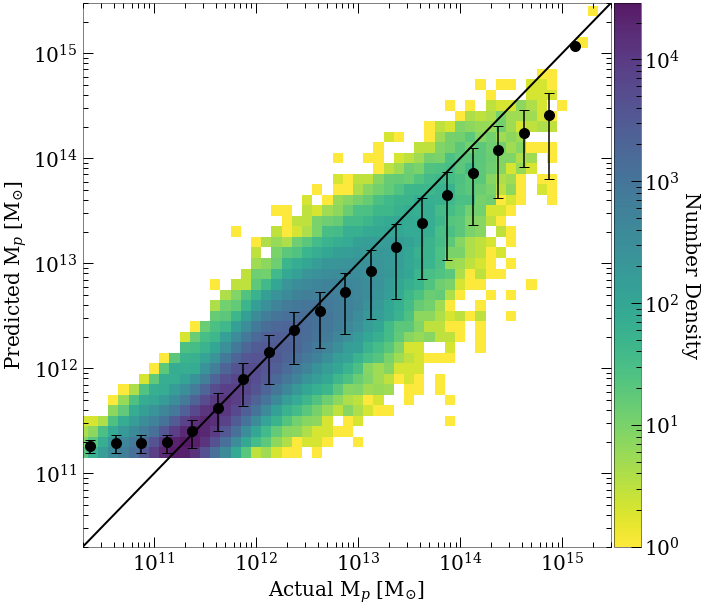

In [137]:
#Plot results of SM only predictions of HM

bins1 = pow(10,np.arange(9.75,15.5,0.1))
bins2 = np.arange(9.75,15.5,0.25)
PvA_plot(bins1,bins2,pow(10,y_true)/h,pow(10,y_pred)/h)

# Get Outputs Main Models

In [15]:
def get_stats_indiv(model,features,true,bins):
    #Get unscaled output and binned statistics for a given model and set of features
    output = unscale_test_data(get_output(model,features))
    rmse_overall = get_rmse(true,output)
    
    x_edges,x_binned,y_binned,y_std = bin_data(true,output,bins)
    rmse, res = get_binned_rmse_boot(true,output,bins)
    high, low = get_high_low_res(res)
    stats_ind = [rmse_overall,rmse,high,low]
    return output, stats_ind

In [16]:
feature_list_knn50_v1 = get_knn_features1(50) #No redshift info
feature_list_knn50_v2 = get_knn_features2(50) #Yes redshift info

X_test_knn50_v1 = tf.convert_to_tensor(test_scaled[feature_list_knn50_v1])
X_test_knn50_v2 = tf.convert_to_tensor(test_scaled[feature_list_knn50_v2])

X_test_cyl = test_scaled[test_scaled.filter(like='Cylinder').columns]
X_test_cyl['Stellar Mass'] = test_scaled['Stellar_Mass(0)']

combo_feature_list = np.concatenate([np.array(feature_list_knn50_v1),
                                    np.array(test_scaled.filter(like='Cylinder').columns)])
X_test_combo = test_scaled[combo_feature_list]

In [23]:
#Iterate through default models

models_u = [model_knn_u,model_cyl_u,model_combo_u,model_knn_uz]
models_w = [model_knn_w,model_cyl_w,model_combo_w,model_knn_wz]
features = [X_test_knn50_v1,X_test_cyl,X_test_combo,X_test_knn50_v2]

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)

outputs_u = []
outputs_w = []
stats_u = []
stats_w = []

for i in range(len(models_u)):
    output_u, stats_u_ind = get_stats_indiv(models_u[i],features[i],y_true,bins)
    outputs_u.append(output_u)
    stats_u.append(stats_u_ind)
    
    output_w, stats_w_ind = get_stats_indiv(models_w[i],features[i],y_true,bins)
    outputs_w.append(output_w)
    stats_w.append(stats_w_ind)

21737/21737 [==============================] - 9s 406us/step


In [45]:
def plot_errors(ylim):
    #Plot RMSE vs. True Halo Mass
    
    plt.rcParams['font.size']= 20

    fig,ax = plt.subplots(figsize=(12,8),facecolor='w')

    ax.set_xlabel(r'True M$_p$ [M$_{\odot}$]')
    ax.set_ylabel('Root Mean Squared Error [dex]')
    
    ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')

    ax.set(xlim=(pow(10,10.6)/h,pow(10,15.08)/h),ylim=(0,ylim),xscale='log')

    x_ticks = pow(10,np.array([11,12,13,14,15]))
    ax.xaxis.set_major_locator(FixedLocator(x_ticks))
    ax.xaxis.set_minor_locator(LogLocator(subs=np.arange(0.1,1,0.1)))

    ax.tick_params(which='major', width=1.0, length=10,labelsize=20,pad=5)
    ax.tick_params(which='minor', width=1.0, length=5)

    
    return fig, ax

0.19132883584402635
0.20019786617606536


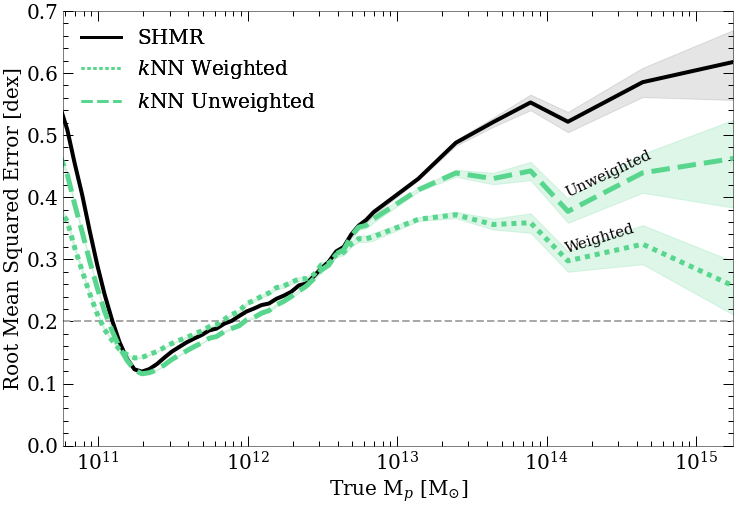

In [196]:
ylim=0.7
fig, ax = plot_errors(ylim)

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)


ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=4)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')


labels = ['kNN(50)','Cylinder','Combo','kNN+z']
ls = ['dashed','dotted','dashdot']
    
for i in [0]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])

handles1 = [mpl.lines.Line2D([],[],color='black',ls='solid',label=r'SHMR',lw=3),
           mpl.lines.Line2D([],[],color=colors[1],ls=(0,(1,1)),label=r'$k$NN Weighted',lw=3),
           mpl.lines.Line2D([],[],color=colors[1],ls='dashed',label=r'$k$NN Unweighted',lw=3)]
first_legend = ax.legend(handles=handles1)
ax.add_artist(first_legend)

ax.annotate("Unweighted",(1.3e14,0.40),rotation=25,fontsize=15)
ax.annotate("Weighted",(1.3e14,0.31),rotation=17,fontsize=15)

plt.savefig("Figures/kNN_loss.pdf")

0.19132883584402635
0.20019786617606536
0.19119740758155562
0.19974352290301767


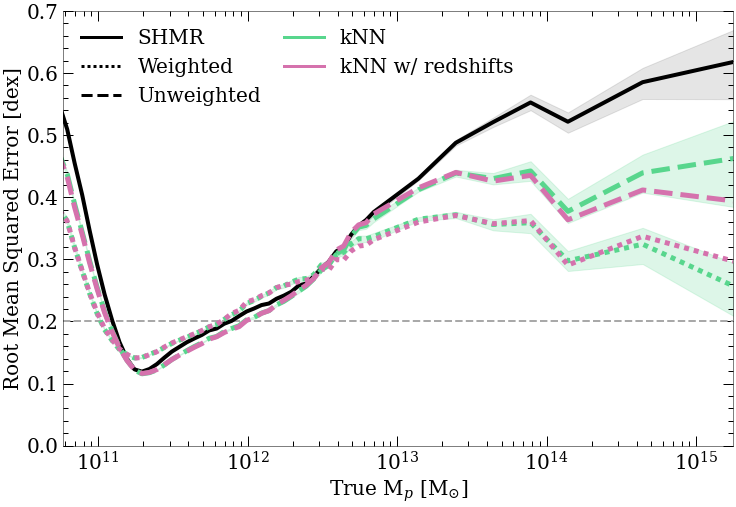

In [232]:
ylim=0.7
fig, ax = plot_errors(ylim)

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)


ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=4)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')


labels = ['kNN(50)','Cylinder','Combo','kNN+z']
ls = ['dashed','dotted','dashdot']

for i in [0]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=5,c=colors[i+1],alpha=1.0)
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=5,c=colors[i+1],alpha=1.0)
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
for i in [3]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=5,c=colors[i+1])

    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=5,c=colors[i+1])

handles1 = [mpl.lines.Line2D([],[],color='black',ls='solid',label=r'SHMR',lw=3),
           mpl.lines.Line2D([],[],color='black',ls=(0,(1,1)),label=r'Weighted',lw=3),
           mpl.lines.Line2D([],[],color='black',ls='dashed',label=r'Unweighted',lw=3)]
first_legend = ax.legend(handles=handles1)
ax.add_artist(first_legend)

handles2 = [mpl.lines.Line2D([],[],color=colors[1],ls='solid',label=r'kNN',lw=3),
           mpl.lines.Line2D([],[],color=colors[4],ls='solid',label=r'kNN w/ redshifts',lw=3),]
ax.legend(handles=handles2,loc='upper center')

plt.savefig("Figures/kNN_z_loss.pdf")

0.19132883584402635
0.20019786617606536
0.19602117864634425
0.2042519030561195


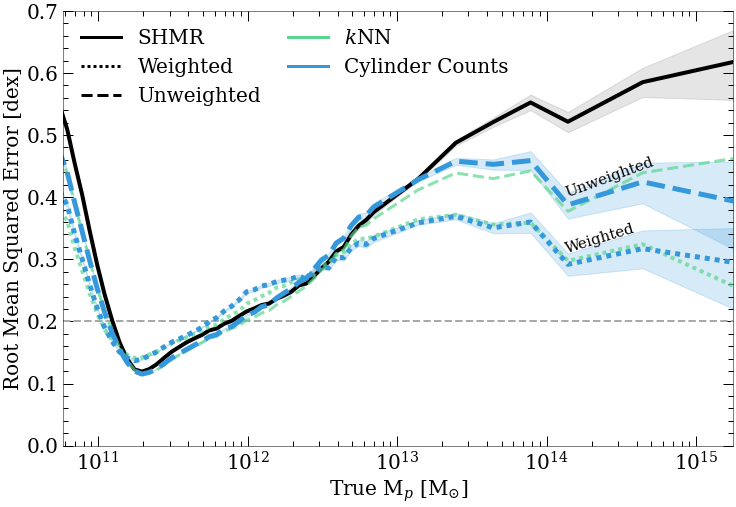

In [197]:
ylim=0.7
fig, ax = plot_errors(ylim)

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)


ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=4)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')


labels = ['kNN(50)','Cylinder','Combo','kNN+z']
ls = ['dashed','dotted','dashdot']

for i in [0]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=3,c=colors[i+1],alpha=0.7)

    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=4,c=colors[i+1],alpha=0.7)
    
for i in [1]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])

handles1 = [mpl.lines.Line2D([],[],color='black',ls='solid',label=r'SHMR',lw=3),
           mpl.lines.Line2D([],[],color='black',ls=(0,(1,1)),label=r'Weighted',lw=3),
           mpl.lines.Line2D([],[],color='black',ls='dashed',label=r'Unweighted',lw=3)]
first_legend = ax.legend(handles=handles1)
ax.add_artist(first_legend)

handles2 = [mpl.lines.Line2D([],[],color=colors[1],ls='solid',label=r'$k$NN',lw=3),
           mpl.lines.Line2D([],[],color=colors[2],ls='solid',label=r'Cylinder Counts',lw=3),]
ax.legend(handles=handles2,loc='upper center')

ax.annotate("Unweighted",(1.3e14,0.40),rotation=20,fontsize=15)
ax.annotate("Weighted",(1.3e14,0.31),rotation=17,fontsize=15)

plt.savefig("Figures/Cylinder_loss.pdf")

0.19132883584402635
0.20019786617606536
0.19602117864634425
0.2042519030561195
0.19067541729909387
0.1986664797706813


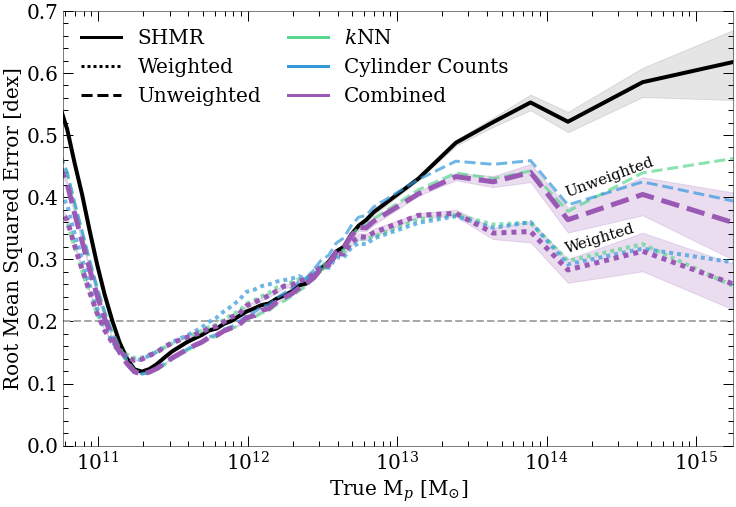

In [198]:
ylim=0.7
fig, ax = plot_errors(ylim)

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)


ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=4)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')


labels = ['kNN(50)','Cylinder','Combo','kNN+z']
ls = ['dashed','dotted','dashdot']

for i in range(2):
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=3,c=colors[i+1],alpha=0.7)
    #ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i])
    
    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=4,c=colors[i+1],alpha=0.7)
    #ax.fill_between(pow(10,bin_centers)/h,stats[2],stats[3],alpha=0.2,color=colors[i],hatch='x')
    
for i in [2]:
    stats_i = stats_u[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle='dashed',lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
    stats_i = stats_w[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],linestyle=(0,(1,1)),lw=5,c=colors[i+1])
    ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])

handles1 = [mpl.lines.Line2D([],[],color='black',ls='solid',label=r'SHMR',lw=3),
           mpl.lines.Line2D([],[],color='black',ls=(0,(1,1)),label=r'Weighted',lw=3),
           mpl.lines.Line2D([],[],color='black',ls='dashed',label=r'Unweighted',lw=3)]
first_legend = ax.legend(handles=handles1)
ax.add_artist(first_legend)

handles2 = [mpl.lines.Line2D([],[],color=colors[1],ls='solid',label=r'$k$NN',lw=3),
           mpl.lines.Line2D([],[],color=colors[2],ls='solid',label=r'Cylinder Counts',lw=3),
           mpl.lines.Line2D([],[],color=colors[3],ls='solid',label=r'Combined',lw=3)]
ax.legend(handles=handles2,loc='upper center')

ax.annotate("Unweighted",(1.3e14,0.40),rotation=20,fontsize=15)
ax.annotate("Weighted",(1.3e14,0.31),rotation=17,fontsize=15)

plt.savefig("Figures/Combo_loss.pdf")

# Compare KNN vs. Cylinder

We compare the rmse errors of the kNN model (no redshift info) and the cylinder model

In [159]:
kNN_error = np.log10(pow(10,outputs_w[0])/h) - np.log10(pow(10,y_true)/h)
Cylinder_error = np.log10(pow(10,outputs_w[1])/h) - np.log10(pow(10,y_true)/h)

In [160]:
#Correlation coefficient between the two outputs
np.corrcoef(outputs_w[0], outputs_w[1])

array([[1.        , 0.98878474],
       [0.98878474, 1.        ]])

In [161]:
#Correlation coefficient between the errors of the two outputs
np.corrcoef(kNN_error, Cylinder_error)

array([[1.        , 0.93457406],
       [0.93457406, 1.        ]])

In [41]:
#Pearson correlation coefficient (r) between kNN model predictions and the true halo mass values
from scipy.stats.stats import pearsonr
pearsonr(outputs_w[0], y_true)

(0.9146165521375893, 0.0)

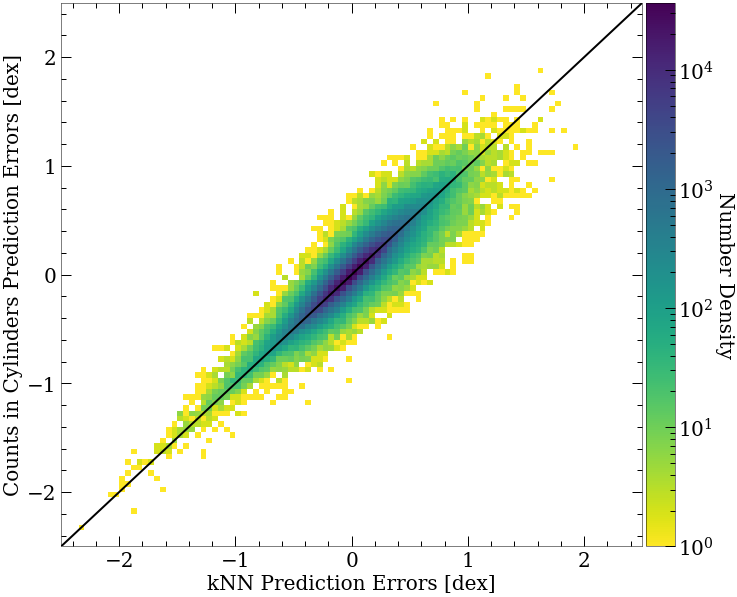

In [154]:
plt.style.use(['science','no-latex'])
plt.rcParams['font.size']= 20

fig = plt.figure(figsize=(11, 10),facecolor='w')

bins = np.arange(-2.5,2.5,0.05)

ax = fig.add_subplot()
h2d = ax.hist2d(kNN_error,Cylinder_error,
          bins=[bins,bins],cmap='viridis_r',norm=mcolors.LogNorm(),alpha=1.0)
ax.set(xlabel=r'kNN Prediction Errors [dex]',
       ylabel=r'Counts in Cylinders Prediction Errors [dex]',
       xscale='linear',yscale='linear')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(h2d[3],cax=cax)
cax.tick_params(axis="y")
cax.yaxis.set_major_locator(FixedLocator([1,10,1e2,1e3,1e4]))
cax_ticks = [0,1,2,3,4]
cax.yaxis.set_ticklabels(["$10^{{{:d}}}$".format(y) for y in cax_ticks],
                         fontsize=20)
cax.set_ylabel(r'Number Density',rotation=270,labelpad=20)

x_ticks = np.array([-2,-1,0,1,2])
ax.xaxis.set_major_locator(FixedLocator(x_ticks))

y_ticks = np.array([-2,-1,0,1,2])
ax.yaxis.set_major_locator(FixedLocator(y_ticks))

ax.tick_params(which='major', width=1.0, length=10,labelsize=20,pad=5)
ax.tick_params(which='minor', width=1.0, length=5)

cax.tick_params(which='major', width=1.0, length=10,labelsize=20)
cax.tick_params(which='minor', width=1.0, length=5)

x = np.arange(-3,3,0.1)
ax.plot(x,x,c='k',lw=2,ls='solid')


ax.set(xlim=(-2.5,2.5),ylim=(-2.5,2.5))
plt.savefig("Figures/prediction_errs.pdf")

# Centrals vs. Satellites

Using same models as above, split the test population into centrals and satellites and evaluate performances

In [38]:
#Define populations
centrals_test = test_scaled[test_scaled['UPID']==-1]
satellites_test = test_scaled[test_scaled['UPID']!=-1]

true_cen = BP_combo[BP_combo['UPID']==-1]
true_sats = BP_combo[BP_combo['UPID']!=-1]

In [39]:
#SHMR interpolation

x_true_cen = np.log10(true_cen['Stellar_Mass(0)'])
y_true_cen = np.log10(true_cen['Halo_Mass'])
y_pred_cen = f3(x_true_cen)

x_true_sats = np.log10(true_sats['Stellar_Mass(0)'])
y_true_sats = np.log10(true_sats['Halo_Mass'])
y_pred_sats = f3(x_true_sats)

In [47]:
bins1 = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
rmse_cen, res_cen = get_binned_rmse_boot(y_true_cen,y_pred_cen,bins1)
high_res_cen, low_res_cen = get_high_low_res(res_cen)

SM_rmse, SM_res = get_binned_rmse_boot(y_true,y_pred,bins1)
SM_high_res, SM_low_res = get_high_low_res(SM_res)

bins2 = np.append(np.arange(10.5,12.1,0.05),[12.25,12.5,12.75,13,13.25,13.5,14,14.5])
rmse_sats, res_sats = get_binned_rmse_boot(y_true_sats,y_pred_sats,bins2)
high_res_sats, low_res_sats = get_high_low_res(res_sats)

print(get_rmse(y_true,y_pred))
print(get_rmse(y_true_cen,y_pred_cen))
print(get_rmse(y_true_sats,y_pred_sats))

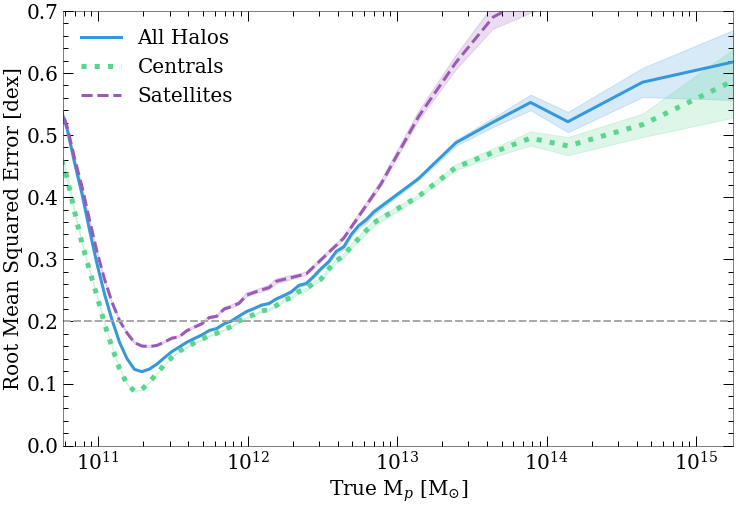

In [165]:
ylim=0.7
fig, ax = plot_errors(ylim)

bin_centers1 = get_bin_centers(bins1)
bin_centers2 = get_bin_centers(bins2)

ax.plot(pow(10,bin_centers1)/h,SM_rmse,c=colors[2],label='All Halos',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers1)/h,SM_low_res,SM_high_res,alpha=0.2,color=colors[2])

ax.plot(pow(10,bin_centers1)/h,rmse_cen,c=colors[1],label='Centrals',linestyle='dotted',lw=5)
ax.fill_between(pow(10,bin_centers1)/h,low_res_cen,high_res_cen,alpha=0.2,color=colors[1])

ax.plot(pow(10,bin_centers2)/h,rmse_sats,c=colors[3],label='Satellites',linestyle='dashed',lw=3)
ax.fill_between(pow(10,bin_centers2)/h,low_res_sats,high_res_sats,alpha=0.2,color=colors[3])


ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')
ax.legend(frameon=False,loc=2)

plt.savefig("Figures/SM_CvS.pdf")

In [102]:
def get_sats_cens(model,feature_list):
    #Get predictions for satellites and centrals separately
    y_pred_nn = get_output(model,test_scaled[feature_list])
    y_pred_nn = unscale_test_data(y_pred_nn)
    
    y_pred_cen_nn = get_output(model,centrals_test[feature_list])
    y_pred_cen_nn = unscale_test_data(y_pred_cen_nn)
    
    y_pred_sats_nn = get_output(model,satellites_test[feature_list])
    y_pred_sats_nn = unscale_test_data(y_pred_sats_nn)
    
    return (y_pred_nn,y_pred_cen_nn,y_pred_sats_nn)

In [169]:
#Replace combo_feature_list and [#] with the values of your choice
pred, pred_cen, pred_sats = get_sats_cens(models_w[2],combo_feature_list)

print(get_rmse(y_true,pred))
print(get_rmse(y_true_cen,pred_cen))
print(get_rmse(y_true_sats,pred_sats))

6997/6997 [==============================] - 2s 345us/step


In [174]:
rmse_nn, res_nn = get_binned_rmse_boot(y_true,pred,bins1)
high_res_nn, low_res_nn = get_high_low_res(res_nn)

rmse_cen_nn, res_cen_nn = get_binned_rmse_boot(y_true_cen,pred_cen,bins1)
high_res_cen_nn, low_res_cen_nn = get_high_low_res(res_cen_nn)

rmse_sats_nn, res_sats_nn = get_binned_rmse_boot(y_true_sats,pred_sats,bins2)
high_res_sats_nn, low_res_sats_nn = get_high_low_res(res_sats_nn)

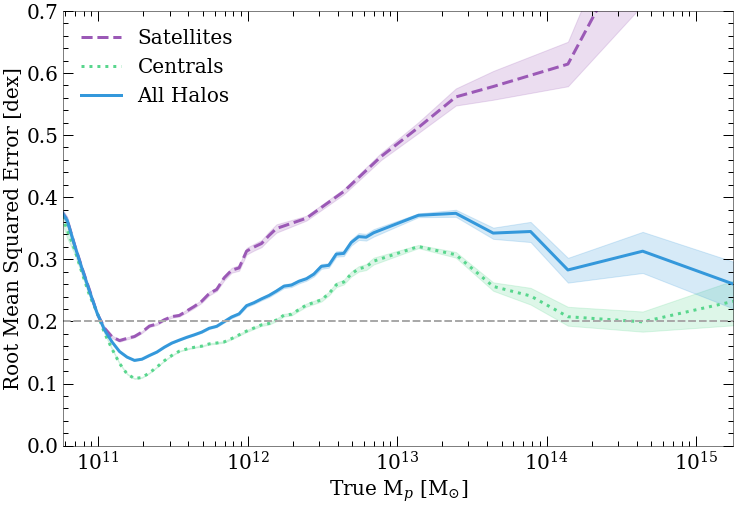

In [175]:
ylim=0.7
fig, ax = plot_errors(ylim)

bin_centers1 = get_bin_centers(bins1)
bin_centers2 = get_bin_centers(bins2)

ax.plot(pow(10,bin_centers2)/h,rmse_sats_nn,c=colors[3],label='Satellites',linestyle='dashed',lw=3)
ax.fill_between(pow(10,bin_centers2)/h,low_res_sats_nn,high_res_sats_nn,alpha=0.2,color=colors[3])

ax.plot(pow(10,bin_centers1)/h,rmse_cen_nn,c=colors[1],label='Centrals',linestyle='dotted',lw=3)
ax.fill_between(pow(10,bin_centers1)/h,low_res_cen_nn,high_res_cen_nn,alpha=0.2,color=colors[1])

ax.plot(pow(10,bin_centers1)/h,rmse_nn,c=colors[2],label='All Halos',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers1)/h,low_res_nn,high_res_nn,alpha=0.2,color=colors[2])

ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')
ax.legend(frameon=False,loc=2)

plt.savefig("Figures/Combo_CvS.pdf")

# Best Performer PvA

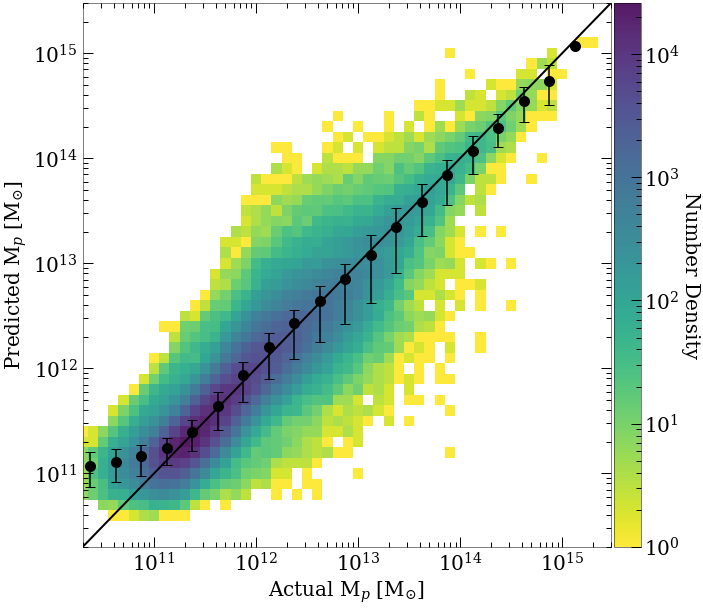

In [170]:
bins1 = pow(10,np.arange(9.75,15.5,0.1))
bins2 = np.arange(9.75,15.5,0.25)
PvA_plot(bins1,bins2,pow(10,y_true)/h,pow(10,outputs_w[2])/h)

# Training History

In [99]:
history = h5py.File('Models/run_6_5/history_knn50_u.h5','r') #replace with model history of your choice

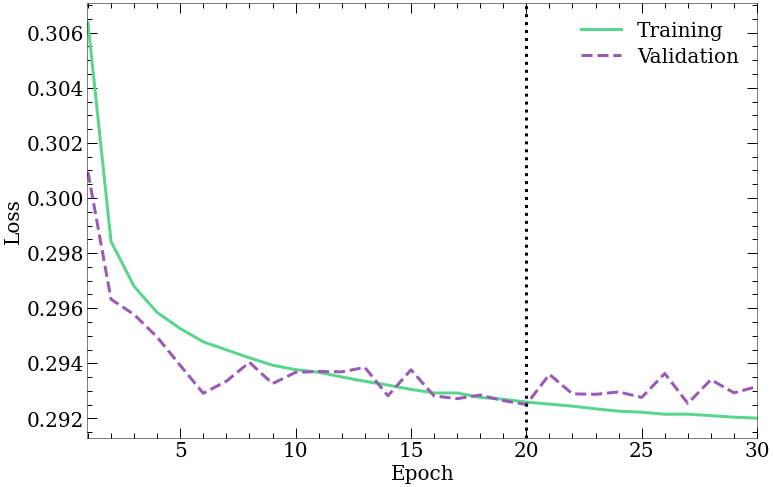

In [176]:
#Validation loss vs. epoch for diferent models

plt.rcParams['font.size']= 20
import scienceplots
plt.style.use(['science','no-latex'])

fig,ax2 = plt.subplots(figsize=(12,8),facecolor='w')

epochs = np.arange(1,len(history['loss'][:])+1)
ax2.plot(epochs,history['loss'][:],ls='solid',color=colors[1],lw=3,label='Training')
ax2.plot(epochs,history['val_loss'][:],ls='dashed',color=colors[3],lw=3,label='Validation')

ax2.set(xlabel='Epoch',ylabel='Loss',xlim=(0.98,30)) #log scale for y axis?

ax2.tick_params(which='major', width=1.0, length=10,labelsize=20)
ax2.tick_params(which='minor', width=1.0, length=5)

best_epoch = np.where(history['val_loss']==np.min(history['val_loss']))[0][0]+1
ax2.axvline(best_epoch,color='k',ls='dotted',lw=3)

plt.legend(loc=1,fontsize=20,markerscale=2.0,
          labelspacing=0.35,frameon=False)

plt.savefig("Figures/Training_Loss.pdf")

# Neighbors Feature Importance

In [178]:
def mask_column(full,column_names):
    #Replace values in columns to be masked with 0
    x = full.copy()
    for name in column_names:
        x[name].values[:] = 0
    return x

In [179]:
feature_list_knn50 = get_knn_features1(50)

indices_25 = np.arange(51,101,1) #retain first 25 neighbors
indices_10 = np.arange(21,101,1) #10 neighbors
indices_5 = np.arange(11,101,1) #5 neighbors
indices_1 = np.arange(3,101,1) #1 neighbor

In [99]:
D25_train = tf.convert_to_tensor(mask_column(train[feature_list_knn50_v1],
                                 train[feature_list_knn50_v1].keys()[indices_25]))
D25_val = tf.convert_to_tensor(mask_column(val[feature_list_knn50_v1],
                                 val[feature_list_knn50_v1].keys()[indices_25]))
D10_train = tf.convert_to_tensor(mask_column(train[feature_list_knn50_v1],
                                 train[feature_list_knn50_v1].keys()[indices_10]))
D10_val = tf.convert_to_tensor(mask_column(val[feature_list_knn50_v1],
                                 val[feature_list_knn50_v1].keys()[indices_10]))
D5_train = tf.convert_to_tensor(mask_column(train[feature_list_knn50_v1],
                                 train[feature_list_knn50_v1].keys()[indices_5]))
D5_val = tf.convert_to_tensor(mask_column(val[feature_list_knn50_v1],
                                 val[feature_list_knn50_v1].keys()[indices_5]))
D1_train = tf.convert_to_tensor(mask_column(train[feature_list_knn50_v1],
                                 train[feature_list_knn50_v1].keys()[indices_1]))
D1_val = tf.convert_to_tensor(mask_column(val[feature_list_knn50_v1],
                                 val[feature_list_knn50_v1].keys()[indices_1]))

In [100]:
use_weights = 0
model_knn25_u,history_knn25_u = train_model("knn25_u",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D25_train,D25_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn10_u,history_knn10_u = train_model("knn10_u",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D10_train,D10_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn5_u,history_knn5_u = train_model("knn5_u",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D5_train,D5_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn1_u,history_knn1_u = train_model("knn1_u",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D1_train,D1_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

use_weights = 1
model_knn25_w,history_knn25_w = train_model("knn25_w",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D25_train,D25_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn10_w,history_knn10_w = train_model("knn10_w",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D10_train,D10_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn5_w,history_knn5_w = train_model("knn5_w",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D5_train,D5_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
model_knn1_w,history_knn1_w = train_model("knn1_w",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        D1_train,D1_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

knn25_u
Epoch 1/50
16006/16006 - 24s - loss: 0.3033 - mean_squared_error: 0.1745 - mean_absolute_error: 0.3033 - val_loss: 0.2989 - val_mean_squared_error: 0.1731 - val_mean_absolute_error: 0.2989 - 24s/epoch - 2ms/step
Epoch 2/50
16006/16006 - 23s - loss: 0.2974 - mean_squared_error: 0.1682 - mean_absolute_error: 0.2974 - val_loss: 0.2960 - val_mean_squared_error: 0.1656 - val_mean_absolute_error: 0.2960 - 23s/epoch - 1ms/step
Epoch 3/50
16006/16006 - 22s - loss: 0.2960 - mean_squared_error: 0.1668 - mean_absolute_error: 0.2960 - val_loss: 0.2935 - val_mean_squared_error: 0.1643 - val_mean_absolute_error: 0.2935 - 22s/epoch - 1ms/step
Epoch 4/50
16006/16006 - 23s - loss: 0.2953 - mean_squared_error: 0.1660 - mean_absolute_error: 0.2953 - val_loss: 0.2979 - val_mean_squared_error: 0.1709 - val_mean_absolute_error: 0.2979 - 23s/epoch - 1ms/step
Epoch 5/50
16006/16006 - 23s - loss: 0.2948 - mean_squared_error: 0.1655 - mean_absolute_error: 0.2948 - val_loss: 0.2936 - val_mean_squared_err

Epoch 19/50
16006/16006 - 23s - loss: 0.2935 - mean_squared_error: 0.1644 - mean_absolute_error: 0.2935 - val_loss: 0.2923 - val_mean_squared_error: 0.1626 - val_mean_absolute_error: 0.2923 - 23s/epoch - 1ms/step
Epoch 20/50
16006/16006 - 22s - loss: 0.2934 - mean_squared_error: 0.1643 - mean_absolute_error: 0.2934 - val_loss: 0.2923 - val_mean_squared_error: 0.1630 - val_mean_absolute_error: 0.2923 - 22s/epoch - 1ms/step
Epoch 21/50
16006/16006 - 22s - loss: 0.2934 - mean_squared_error: 0.1643 - mean_absolute_error: 0.2934 - val_loss: 0.2929 - val_mean_squared_error: 0.1640 - val_mean_absolute_error: 0.2929 - 22s/epoch - 1ms/step
Epoch 22/50
16006/16006 - 21s - loss: 0.2933 - mean_squared_error: 0.1642 - mean_absolute_error: 0.2933 - val_loss: 0.2922 - val_mean_squared_error: 0.1631 - val_mean_absolute_error: 0.2922 - 21s/epoch - 1ms/step
Epoch 23/50
16006/16006 - 22s - loss: 0.2933 - mean_squared_error: 0.1642 - mean_absolute_error: 0.2933 - val_loss: 0.2927 - val_mean_squared_error:

Epoch 30/50
16006/16006 - 23s - loss: 0.2954 - mean_squared_error: 0.1667 - mean_absolute_error: 0.2954 - val_loss: 0.2940 - val_mean_squared_error: 0.1647 - val_mean_absolute_error: 0.2940 - 23s/epoch - 1ms/step
Epoch 31/50
16006/16006 - 23s - loss: 0.2954 - mean_squared_error: 0.1666 - mean_absolute_error: 0.2954 - val_loss: 0.2948 - val_mean_squared_error: 0.1678 - val_mean_absolute_error: 0.2948 - 23s/epoch - 1ms/step
Epoch 32/50
16006/16006 - 24s - loss: 0.2954 - mean_squared_error: 0.1667 - mean_absolute_error: 0.2954 - val_loss: 0.2953 - val_mean_squared_error: 0.1681 - val_mean_absolute_error: 0.2953 - 24s/epoch - 2ms/step
Epoch 33/50
16006/16006 - 24s - loss: 0.2954 - mean_squared_error: 0.1667 - mean_absolute_error: 0.2954 - val_loss: 0.2951 - val_mean_squared_error: 0.1657 - val_mean_absolute_error: 0.2951 - 24s/epoch - 1ms/step
Epoch 34/50
16006/16006 - 22s - loss: 0.2954 - mean_squared_error: 0.1667 - mean_absolute_error: 0.2954 - val_loss: 0.2943 - val_mean_squared_error:

Epoch 19/50
16006/16006 - 24s - loss: 0.3086 - mean_squared_error: 0.1798 - mean_absolute_error: 0.3086 - val_loss: 0.3068 - val_mean_squared_error: 0.1780 - val_mean_absolute_error: 0.3068 - 24s/epoch - 1ms/step
Epoch 20/50
16006/16006 - 23s - loss: 0.3086 - mean_squared_error: 0.1798 - mean_absolute_error: 0.3086 - val_loss: 0.3070 - val_mean_squared_error: 0.1775 - val_mean_absolute_error: 0.3070 - 23s/epoch - 1ms/step
Epoch 21/50
16006/16006 - 23s - loss: 0.3086 - mean_squared_error: 0.1797 - mean_absolute_error: 0.3086 - val_loss: 0.3085 - val_mean_squared_error: 0.1783 - val_mean_absolute_error: 0.3085 - 23s/epoch - 1ms/step
Epoch 22/50
16006/16006 - 24s - loss: 0.3086 - mean_squared_error: 0.1798 - mean_absolute_error: 0.3086 - val_loss: 0.3066 - val_mean_squared_error: 0.1777 - val_mean_absolute_error: 0.3066 - 24s/epoch - 1ms/step
Epoch 23/50
16006/16006 - 23s - loss: 0.3086 - mean_squared_error: 0.1797 - mean_absolute_error: 0.3086 - val_loss: 0.3070 - val_mean_squared_error:

Epoch 14/50
16006/16006 - 25s - loss: 0.4766 - mean_squared_error: 0.1761 - mean_absolute_error: 0.3069 - weighted_mean_squared_error: 0.2677 - weighted_mean_absolute_error: 0.3707 - val_loss: 0.4778 - val_mean_squared_error: 0.1753 - val_mean_absolute_error: 0.3073 - val_weighted_mean_squared_error: 0.2697 - val_weighted_mean_absolute_error: 0.3715 - 25s/epoch - 2ms/step
Epoch 15/50
16006/16006 - 25s - loss: 0.4762 - mean_squared_error: 0.1760 - mean_absolute_error: 0.3068 - weighted_mean_squared_error: 0.2671 - weighted_mean_absolute_error: 0.3705 - val_loss: 0.4776 - val_mean_squared_error: 0.1704 - val_mean_absolute_error: 0.3011 - val_weighted_mean_squared_error: 0.2727 - val_weighted_mean_absolute_error: 0.3713 - 25s/epoch - 2ms/step
Epoch 16/50
16006/16006 - 26s - loss: 0.4759 - mean_squared_error: 0.1759 - mean_absolute_error: 0.3067 - weighted_mean_squared_error: 0.2669 - weighted_mean_absolute_error: 0.3702 - val_loss: 0.4772 - val_mean_squared_error: 0.1710 - val_mean_absolu

Epoch 2/50
16006/16006 - 25s - loss: 0.4903 - mean_squared_error: 0.1810 - mean_absolute_error: 0.3113 - weighted_mean_squared_error: 0.2821 - weighted_mean_absolute_error: 0.3814 - val_loss: 0.4849 - val_mean_squared_error: 0.1830 - val_mean_absolute_error: 0.3157 - val_weighted_mean_squared_error: 0.2756 - val_weighted_mean_absolute_error: 0.3770 - 25s/epoch - 2ms/step
Epoch 3/50
16006/16006 - 25s - loss: 0.4866 - mean_squared_error: 0.1794 - mean_absolute_error: 0.3098 - weighted_mean_squared_error: 0.2786 - weighted_mean_absolute_error: 0.3786 - val_loss: 0.4819 - val_mean_squared_error: 0.1726 - val_mean_absolute_error: 0.3039 - val_weighted_mean_squared_error: 0.2777 - val_weighted_mean_absolute_error: 0.3746 - 25s/epoch - 2ms/step
Epoch 4/50
16006/16006 - 25s - loss: 0.4845 - mean_squared_error: 0.1787 - mean_absolute_error: 0.3090 - weighted_mean_squared_error: 0.2762 - weighted_mean_absolute_error: 0.3769 - val_loss: 0.4802 - val_mean_squared_error: 0.1760 - val_mean_absolute_

Epoch 24/50
16006/16006 - 25s - loss: 0.4771 - mean_squared_error: 0.1762 - mean_absolute_error: 0.3065 - weighted_mean_squared_error: 0.2685 - weighted_mean_absolute_error: 0.3712 - val_loss: 0.4797 - val_mean_squared_error: 0.1699 - val_mean_absolute_error: 0.3023 - val_weighted_mean_squared_error: 0.2764 - val_weighted_mean_absolute_error: 0.3730 - 25s/epoch - 2ms/step
Epoch 25/50
16006/16006 - 26s - loss: 0.4772 - mean_squared_error: 0.1762 - mean_absolute_error: 0.3065 - weighted_mean_squared_error: 0.2688 - weighted_mean_absolute_error: 0.3712 - val_loss: 0.4783 - val_mean_squared_error: 0.1753 - val_mean_absolute_error: 0.3070 - val_weighted_mean_squared_error: 0.2726 - val_weighted_mean_absolute_error: 0.3719 - 26s/epoch - 2ms/step
knn5_w
Epoch 1/50
16006/16006 - 119s - loss: 0.5063 - mean_squared_error: 0.1882 - mean_absolute_error: 0.3179 - weighted_mean_squared_error: 0.3012 - weighted_mean_absolute_error: 0.3939 - val_loss: 0.4925 - val_mean_squared_error: 0.1811 - val_mean

Epoch 21/50
16006/16006 - 25s - loss: 0.4847 - mean_squared_error: 0.1790 - mean_absolute_error: 0.3091 - weighted_mean_squared_error: 0.2761 - weighted_mean_absolute_error: 0.3770 - val_loss: 0.4834 - val_mean_squared_error: 0.1794 - val_mean_absolute_error: 0.3086 - val_weighted_mean_squared_error: 0.2761 - val_weighted_mean_absolute_error: 0.3758 - 25s/epoch - 2ms/step
Epoch 22/50
16006/16006 - 25s - loss: 0.4844 - mean_squared_error: 0.1790 - mean_absolute_error: 0.3090 - weighted_mean_squared_error: 0.2756 - weighted_mean_absolute_error: 0.3768 - val_loss: 0.4842 - val_mean_squared_error: 0.1802 - val_mean_absolute_error: 0.3085 - val_weighted_mean_squared_error: 0.2782 - val_weighted_mean_absolute_error: 0.3764 - 25s/epoch - 2ms/step
Epoch 23/50
16006/16006 - 25s - loss: 0.4841 - mean_squared_error: 0.1791 - mean_absolute_error: 0.3090 - weighted_mean_squared_error: 0.2756 - weighted_mean_absolute_error: 0.3766 - val_loss: 0.4838 - val_mean_squared_error: 0.1726 - val_mean_absolu

Epoch 43/50
16006/16006 - 26s - loss: 0.4831 - mean_squared_error: 0.1786 - mean_absolute_error: 0.3086 - weighted_mean_squared_error: 0.2742 - weighted_mean_absolute_error: 0.3758 - val_loss: 0.4852 - val_mean_squared_error: 0.1795 - val_mean_absolute_error: 0.3102 - val_weighted_mean_squared_error: 0.2770 - val_weighted_mean_absolute_error: 0.3773 - 26s/epoch - 2ms/step
Epoch 44/50
16006/16006 - 26s - loss: 0.4832 - mean_squared_error: 0.1787 - mean_absolute_error: 0.3087 - weighted_mean_squared_error: 0.2743 - weighted_mean_absolute_error: 0.3759 - val_loss: 0.4847 - val_mean_squared_error: 0.1805 - val_mean_absolute_error: 0.3114 - val_weighted_mean_squared_error: 0.2779 - val_weighted_mean_absolute_error: 0.3769 - 26s/epoch - 2ms/step
Epoch 45/50
16006/16006 - 26s - loss: 0.4831 - mean_squared_error: 0.1786 - mean_absolute_error: 0.3086 - weighted_mean_squared_error: 0.2743 - weighted_mean_absolute_error: 0.3758 - val_loss: 0.4855 - val_mean_squared_error: 0.1747 - val_mean_absolu

Epoch 20/50
16006/16006 - 24s - loss: 0.5174 - mean_squared_error: 0.1913 - mean_absolute_error: 0.3219 - weighted_mean_squared_error: 0.3102 - weighted_mean_absolute_error: 0.4025 - val_loss: 0.5173 - val_mean_squared_error: 0.1844 - val_mean_absolute_error: 0.3153 - val_weighted_mean_squared_error: 0.3147 - val_weighted_mean_absolute_error: 0.4022 - 24s/epoch - 1ms/step
Epoch 21/50
16006/16006 - 25s - loss: 0.5175 - mean_squared_error: 0.1912 - mean_absolute_error: 0.3219 - weighted_mean_squared_error: 0.3098 - weighted_mean_absolute_error: 0.4026 - val_loss: 0.5193 - val_mean_squared_error: 0.1969 - val_mean_absolute_error: 0.3260 - val_weighted_mean_squared_error: 0.3119 - val_weighted_mean_absolute_error: 0.4038 - 25s/epoch - 2ms/step


In [180]:
X_test_knn50 = tf.convert_to_tensor(test_scaled[feature_list_knn50_v1])
D25_test = tf.convert_to_tensor(mask_column(test_scaled[feature_list_knn50_v1],
                                 test_scaled[feature_list_knn50_v1].keys()[indices_25]))
D10_test = tf.convert_to_tensor(mask_column(test_scaled[feature_list_knn50_v1],
                                 test_scaled[feature_list_knn50_v1].keys()[indices_10]))
D5_test = tf.convert_to_tensor(mask_column(test_scaled[feature_list_knn50_v1],
                                 test_scaled[feature_list_knn50_v1].keys()[indices_5]))
D1_test = tf.convert_to_tensor(mask_column(test_scaled[feature_list_knn50_v1],
                                 test_scaled[feature_list_knn50_v1].keys()[indices_1]))

In [181]:
#Uncomment lines below to load pre-trained models (replace run_6_5 with the directory you stored your models in)

#model_knn_u = tf.keras.models.load_model('Models/run_6_5/net_knn50_u_trained.h5')
#model_knn_w = tf.keras.models.load_model('Models/run_6_5/net_knn50_w_trained.h5')
#model_knn25_u = tf.keras.models.load_model('Models/run_6_5/net_knn25_u_trained.h5')
#model_knn25_w = tf.keras.models.load_model('Models/run_6_5/net_knn25_w_trained.h5')
#model_knn10_u = tf.keras.models.load_model('Models/run_6_5/net_knn10_u_trained.h5')
#model_knn10_w = tf.keras.models.load_model('Models/run_6_5/net_knn10_w_trained.h5')
#model_knn5_u = tf.keras.models.load_model('Models/run_6_5/net_knn5_u_trained.h5')
#model_knn5_w = tf.keras.models.load_model('Models/run_6_5/net_knn5_w_trained.h5')
#model_knn1_u = tf.keras.models.load_model('Models/run_6_5/net_knn1_u_trained.h5')
#model_knn1_w = tf.keras.models.load_model('Models/run_6_5/net_knn1_w_trained.h5')

In [182]:
models_u2 = [model_knn_u,model_knn25_u,model_knn10_u,model_knn5_u,model_knn1_u]
models_w2 = [model_knn_w,model_knn25_w,model_knn10_w,model_knn5_w,model_knn1_w]
features2 = [X_test_knn50_v1,D25_test,D10_test,D5_test,D1_test]

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)

outputs_u2 = []
outputs_w2 = []
stats_u2 = []
stats_w2 = []

for i in range(len(models_u2)):
    output_u2, stats_u2_ind = get_stats_indiv(models_u2[i],features2[i],y_true,bins)
    outputs_u2.append(output_u2)
    stats_u2.append(stats_u2_ind)
    
    output_w2, stats_w2_ind = get_stats_indiv(models_w2[i],features2[i],y_true,bins)
    outputs_w2.append(output_w2)
    stats_w2.append(stats_w2_ind)

21737/21737 [==============================] - 8s 344us/step


0.19132883584402635
0.19166439478785682
0.19170723240624685
0.19313934475985295
0.19962778230251949


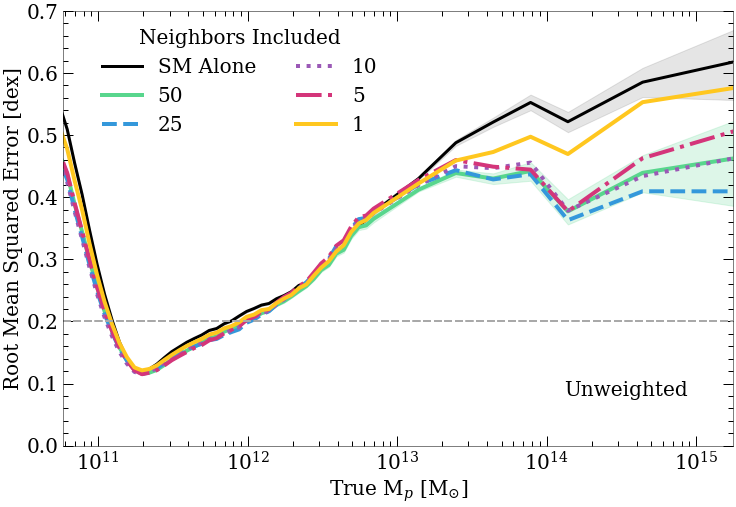

In [184]:
fig, ax = plot_errors(ylim)

ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')

labels = ['50','25','10','5','1']
ls = ['solid','dashed','dotted','dashdot','solid']
hatches = [None,'o','x','-',None]

colors_order = [colors[1],colors[2],colors[3],colors[4],colors[0]]
for i in range(len(stats_u2)):
    stats_i = stats_u2[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=colors_order[i])
    if i == 0:
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors_order[i])
    
    ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')

ax.legend(frameon=False,loc=2,ncol=2,title='Neighbors Included',
          bbox_to_anchor=(0.03, 0.5, 0.5, 0.5))

ax.annotate("Unweighted",(1.3e14,0.08),fontsize=20)

plt.savefig("Figures/knn_u_FI.pdf")

0.20019786617606536
0.19846560422715928
0.20061343829030792
0.20350679360544482
0.2071063526547125


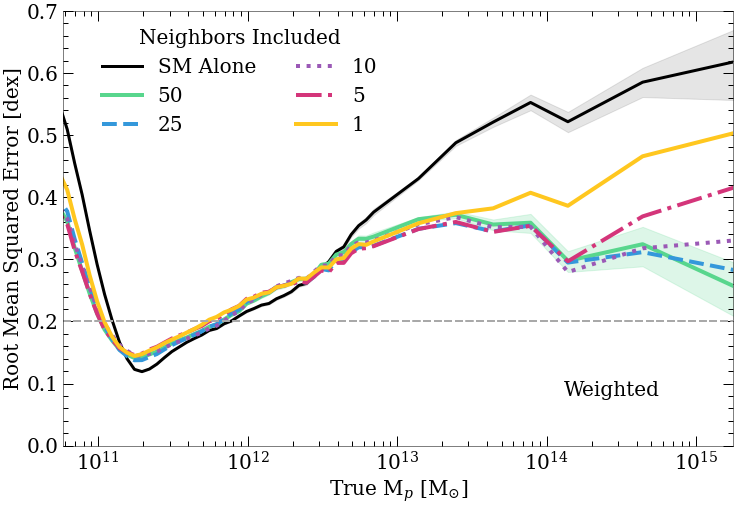

In [185]:
fig, ax = plot_errors(ylim)

ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')

labels = ['50','25','10','5','1']
ls = ['solid','dashed','dotted','dashdot','solid']
hatches = [None,'o','x','-',None]

colors_order = [colors[1],colors[2],colors[3],colors[4],colors[0]]
for i in range(len(stats_w2)):
    stats_i = stats_w2[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=colors_order[i])
    if i == 0:
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors_order[i])
    
    ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')

ax.legend(frameon=False,loc=2,ncol=2,title='Neighbors Included',
          bbox_to_anchor=(0.03, 0.5, 0.5, 0.5))

ax.annotate("Weighted",(1.3e14,0.08),fontsize=20)

plt.savefig("Figures/knn_w_FI.pdf")

# Cylinders Feature Importance

remove more distant redshift bins
+
remove larger cylinders

In [ ]:
#Version 1: mask radii = 5 Mpc
#Version 2: mask radii = 2,5 Mpc
#Version 3: mask radii = 1,2,5 Mpc
#Version 4: mask z_bins > 1000
#Version 5: mask z_bins > 500
#Version 6: mask z_bins > 250

In [105]:
X_train_cyl = train[train.filter(like='Cylinder').columns]
X_train_cyl['Stellar Mass'] = train['Stellar_Mass(0)']

X_val_cyl = val[val.filter(like='Cylinder').columns]
X_val_cyl['Stellar Mass'] = val['Stellar_Mass(0)']

In [186]:
V1_keys = test_scaled.filter(like='_5Mpc').columns
V2_keys = np.append(V1_keys,test_scaled.filter(like='2Mpc').columns)
V3_keys = np.append(V2_keys,test_scaled.filter(like='1Mpc').columns)
V4_keys = test_scaled.filter(like='c_1').columns
V5_keys = test_scaled.filter(like='Cylinder').columns[[2,3,4,5,6,7,
                                                 10,11,12,13,14,15,
                                                 18,19,20,21,22,23,
                                                 26,27,28,29,30,31]]
V6_keys = test_scaled.filter(like='Cylinder').columns[[1,2,3,4,5,6,7,
                                                 9,10,11,12,13,14,15,
                                                 17,18,19,20,21,22,23,
                                                 25,26,27,28,29,30,31]]

In [108]:
#Version 1:
V1_keys = train.filter(like='_5Mpc').columns
V1_train = tf.convert_to_tensor(mask_column(X_train_cyl,V1_keys))
V1_val = tf.convert_to_tensor(mask_column(X_val_cyl,V1_keys))

In [109]:
use_weights = 0
model_cyl1_u,history_cyl1_u = train_model("cyl1_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V1_train,V1_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl1_w,history_cyl1_w = train_model("cyl1_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V1_train,V1_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl1_u
Epoch 1/50
16006/16006 - 10s - loss: 0.3084 - mean_squared_error: 0.1806 - mean_absolute_error: 0.3084 - val_loss: 0.3027 - val_mean_squared_error: 0.1728 - val_mean_absolute_error: 0.3027 - 10s/epoch - 654us/step
Epoch 2/50
16006/16006 - 10s - loss: 0.3040 - mean_squared_error: 0.1750 - mean_absolute_error: 0.3040 - val_loss: 0.3013 - val_mean_squared_error: 0.1718 - val_mean_absolute_error: 0.3013 - 10s/epoch - 601us/step
Epoch 3/50
16006/16006 - 10s - loss: 0.3033 - mean_squared_error: 0.1743 - mean_absolute_error: 0.3033 - val_loss: 0.3025 - val_mean_squared_error: 0.1727 - val_mean_absolute_error: 0.3025 - 10s/epoch - 602us/step
Epoch 4/50
16006/16006 - 10s - loss: 0.3030 - mean_squared_error: 0.1740 - mean_absolute_error: 0.3030 - val_loss: 0.3021 - val_mean_squared_error: 0.1727 - val_mean_absolute_error: 0.3021 - 10s/epoch - 619us/step
Epoch 5/50
16006/16006 - 10s - loss: 0.3027 - mean_squared_error: 0.1736 - mean_absolute_error: 0.3027 - val_loss: 0.3023 - val_mean_squa

Epoch 8/50
16006/16006 - 12s - loss: 0.4919 - mean_squared_error: 0.1864 - mean_absolute_error: 0.3162 - weighted_mean_squared_error: 0.2829 - weighted_mean_absolute_error: 0.3827 - val_loss: 0.4896 - val_mean_squared_error: 0.1821 - val_mean_absolute_error: 0.3122 - val_weighted_mean_squared_error: 0.2842 - val_weighted_mean_absolute_error: 0.3807 - 12s/epoch - 745us/step
Epoch 9/50
16006/16006 - 11s - loss: 0.4914 - mean_squared_error: 0.1859 - mean_absolute_error: 0.3159 - weighted_mean_squared_error: 0.2829 - weighted_mean_absolute_error: 0.3823 - val_loss: 0.4905 - val_mean_squared_error: 0.1846 - val_mean_absolute_error: 0.3141 - val_weighted_mean_squared_error: 0.2815 - val_weighted_mean_absolute_error: 0.3813 - 11s/epoch - 686us/step
Epoch 10/50
16006/16006 - 12s - loss: 0.4910 - mean_squared_error: 0.1858 - mean_absolute_error: 0.3159 - weighted_mean_squared_error: 0.2825 - weighted_mean_absolute_error: 0.3820 - val_loss: 0.4898 - val_mean_squared_error: 0.1839 - val_mean_abso

In [110]:
#Version 2:
V2_keys = np.append(V1_keys,train.filter(like='2Mpc').columns)
V2_train = tf.convert_to_tensor(mask_column(X_train_cyl,V2_keys))
V2_val = tf.convert_to_tensor(mask_column(X_val_cyl,V2_keys))

In [111]:
use_weights = 0
model_cyl2_u,history_cyl2_u = train_model("cyl2_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V2_train,V2_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl2_w,history_cyl2_w = train_model("cyl2_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V2_train,V2_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl2_u
Epoch 1/50
16006/16006 - 11s - loss: 0.3080 - mean_squared_error: 0.1801 - mean_absolute_error: 0.3080 - val_loss: 0.3060 - val_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.3060 - 11s/epoch - 701us/step
Epoch 2/50
16006/16006 - 11s - loss: 0.3040 - mean_squared_error: 0.1751 - mean_absolute_error: 0.3040 - val_loss: 0.3032 - val_mean_squared_error: 0.1732 - val_mean_absolute_error: 0.3032 - 11s/epoch - 681us/step
Epoch 3/50
16006/16006 - 10s - loss: 0.3034 - mean_squared_error: 0.1744 - mean_absolute_error: 0.3034 - val_loss: 0.3015 - val_mean_squared_error: 0.1734 - val_mean_absolute_error: 0.3015 - 10s/epoch - 654us/step
Epoch 4/50
16006/16006 - 10s - loss: 0.3031 - mean_squared_error: 0.1741 - mean_absolute_error: 0.3031 - val_loss: 0.3030 - val_mean_squared_error: 0.1733 - val_mean_absolute_error: 0.3030 - 10s/epoch - 642us/step
Epoch 5/50
16006/16006 - 10s - loss: 0.3029 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3029 - val_loss: 0.3009 - val_mean_squa

Epoch 3/50
16006/16006 - 12s - loss: 0.4949 - mean_squared_error: 0.1877 - mean_absolute_error: 0.3172 - weighted_mean_squared_error: 0.2863 - weighted_mean_absolute_error: 0.3850 - val_loss: 0.4917 - val_mean_squared_error: 0.1781 - val_mean_absolute_error: 0.3095 - val_weighted_mean_squared_error: 0.2883 - val_weighted_mean_absolute_error: 0.3823 - 12s/epoch - 740us/step
Epoch 4/50
16006/16006 - 12s - loss: 0.4935 - mean_squared_error: 0.1867 - mean_absolute_error: 0.3166 - weighted_mean_squared_error: 0.2851 - weighted_mean_absolute_error: 0.3839 - val_loss: 0.4913 - val_mean_squared_error: 0.1790 - val_mean_absolute_error: 0.3101 - val_weighted_mean_squared_error: 0.2837 - val_weighted_mean_absolute_error: 0.3820 - 12s/epoch - 735us/step
Epoch 5/50
16006/16006 - 12s - loss: 0.4930 - mean_squared_error: 0.1866 - mean_absolute_error: 0.3163 - weighted_mean_squared_error: 0.2844 - weighted_mean_absolute_error: 0.3835 - val_loss: 0.4937 - val_mean_squared_error: 0.1869 - val_mean_absol

Epoch 25/50
16006/16006 - 12s - loss: 0.4894 - mean_squared_error: 0.1852 - mean_absolute_error: 0.3154 - weighted_mean_squared_error: 0.2806 - weighted_mean_absolute_error: 0.3807 - val_loss: 0.4962 - val_mean_squared_error: 0.1829 - val_mean_absolute_error: 0.3124 - val_weighted_mean_squared_error: 0.2898 - val_weighted_mean_absolute_error: 0.3858 - 12s/epoch - 722us/step
Epoch 26/50
16006/16006 - 11s - loss: 0.4893 - mean_squared_error: 0.1853 - mean_absolute_error: 0.3154 - weighted_mean_squared_error: 0.2803 - weighted_mean_absolute_error: 0.3807 - val_loss: 0.4926 - val_mean_squared_error: 0.1889 - val_mean_absolute_error: 0.3157 - val_weighted_mean_squared_error: 0.2869 - val_weighted_mean_absolute_error: 0.3830 - 11s/epoch - 677us/step
Epoch 27/50
16006/16006 - 11s - loss: 0.4896 - mean_squared_error: 0.1851 - mean_absolute_error: 0.3153 - weighted_mean_squared_error: 0.2807 - weighted_mean_absolute_error: 0.3808 - val_loss: 0.4895 - val_mean_squared_error: 0.1817 - val_mean_ab

In [112]:
#Version 3:
V3_keys = np.append(V2_keys,train.filter(like='1Mpc').columns)
V3_train = tf.convert_to_tensor(mask_column(X_train_cyl,V3_keys))
V3_val = tf.convert_to_tensor(mask_column(X_val_cyl,V3_keys))

In [113]:
use_weights = 0
model_cyl3_u,history_cyl3_u = train_model("cyl3_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V3_train,V3_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl3_w,history_cyl3_w = train_model("cyl3_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V3_train,V3_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl3_u
Epoch 1/50
16006/16006 - 12s - loss: 0.3077 - mean_squared_error: 0.1798 - mean_absolute_error: 0.3077 - val_loss: 0.3042 - val_mean_squared_error: 0.1753 - val_mean_absolute_error: 0.3042 - 12s/epoch - 752us/step
Epoch 2/50
16006/16006 - 11s - loss: 0.3047 - mean_squared_error: 0.1759 - mean_absolute_error: 0.3047 - val_loss: 0.3031 - val_mean_squared_error: 0.1728 - val_mean_absolute_error: 0.3031 - 11s/epoch - 693us/step
Epoch 3/50
16006/16006 - 10s - loss: 0.3042 - mean_squared_error: 0.1754 - mean_absolute_error: 0.3042 - val_loss: 0.3026 - val_mean_squared_error: 0.1732 - val_mean_absolute_error: 0.3026 - 10s/epoch - 642us/step
Epoch 4/50
16006/16006 - 12s - loss: 0.3040 - mean_squared_error: 0.1751 - mean_absolute_error: 0.3040 - val_loss: 0.3034 - val_mean_squared_error: 0.1745 - val_mean_absolute_error: 0.3034 - 12s/epoch - 731us/step
Epoch 5/50
16006/16006 - 10s - loss: 0.3038 - mean_squared_error: 0.1749 - mean_absolute_error: 0.3038 - val_loss: 0.3026 - val_mean_squa

Epoch 8/50
16006/16006 - 13s - loss: 0.4951 - mean_squared_error: 0.1872 - mean_absolute_error: 0.3171 - weighted_mean_squared_error: 0.2864 - weighted_mean_absolute_error: 0.3851 - val_loss: 0.4956 - val_mean_squared_error: 0.1812 - val_mean_absolute_error: 0.3123 - val_weighted_mean_squared_error: 0.2873 - val_weighted_mean_absolute_error: 0.3853 - 13s/epoch - 805us/step
Epoch 9/50
16006/16006 - 11s - loss: 0.4945 - mean_squared_error: 0.1869 - mean_absolute_error: 0.3169 - weighted_mean_squared_error: 0.2856 - weighted_mean_absolute_error: 0.3847 - val_loss: 0.4927 - val_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.3148 - val_weighted_mean_squared_error: 0.2862 - val_weighted_mean_absolute_error: 0.3830 - 11s/epoch - 718us/step
Epoch 10/50
16006/16006 - 11s - loss: 0.4945 - mean_squared_error: 0.1868 - mean_absolute_error: 0.3167 - weighted_mean_squared_error: 0.2857 - weighted_mean_absolute_error: 0.3847 - val_loss: 0.4938 - val_mean_squared_error: 0.1893 - val_mean_abso

In [114]:
#Version 4:
V4_keys = train.filter(like='c_1').columns
V4_train = tf.convert_to_tensor(mask_column(X_train_cyl,V4_keys))
V4_val = tf.convert_to_tensor(mask_column(X_val_cyl,V4_keys))

In [115]:
use_weights = 0
model_cyl4_u,history_cyl4_u = train_model("cyl4_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V4_train,V4_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl4_w,history_cyl4_w = train_model("cyl4_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V4_train,V4_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl4_u
Epoch 1/50
16006/16006 - 12s - loss: 0.3081 - mean_squared_error: 0.1807 - mean_absolute_error: 0.3081 - val_loss: 0.3030 - val_mean_squared_error: 0.1729 - val_mean_absolute_error: 0.3030 - 12s/epoch - 729us/step
Epoch 2/50
16006/16006 - 11s - loss: 0.3040 - mean_squared_error: 0.1749 - mean_absolute_error: 0.3040 - val_loss: 0.3025 - val_mean_squared_error: 0.1745 - val_mean_absolute_error: 0.3025 - 11s/epoch - 673us/step
Epoch 3/50
16006/16006 - 10s - loss: 0.3034 - mean_squared_error: 0.1744 - mean_absolute_error: 0.3034 - val_loss: 0.3025 - val_mean_squared_error: 0.1725 - val_mean_absolute_error: 0.3025 - 10s/epoch - 636us/step
Epoch 4/50
16006/16006 - 11s - loss: 0.3029 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3029 - val_loss: 0.3027 - val_mean_squared_error: 0.1727 - val_mean_absolute_error: 0.3027 - 11s/epoch - 677us/step
Epoch 5/50
16006/16006 - 11s - loss: 0.3027 - mean_squared_error: 0.1737 - mean_absolute_error: 0.3027 - val_loss: 0.3009 - val_mean_squa

Epoch 40/50
16006/16006 - 11s - loss: 0.3014 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3014 - val_loss: 0.3002 - val_mean_squared_error: 0.1712 - val_mean_absolute_error: 0.3002 - 11s/epoch - 699us/step
Epoch 41/50
16006/16006 - 10s - loss: 0.3013 - mean_squared_error: 0.1722 - mean_absolute_error: 0.3013 - val_loss: 0.3005 - val_mean_squared_error: 0.1709 - val_mean_absolute_error: 0.3005 - 10s/epoch - 626us/step
cyl4_w
Epoch 1/50
16006/16006 - 104s - loss: 0.5105 - mean_squared_error: 0.1953 - mean_absolute_error: 0.3239 - weighted_mean_squared_error: 0.3036 - weighted_mean_absolute_error: 0.3971 - val_loss: 0.5135 - val_mean_squared_error: 0.2163 - val_mean_absolute_error: 0.3400 - val_weighted_mean_squared_error: 0.3016 - val_weighted_mean_absolute_error: 0.3992 - 104s/epoch - 6ms/step
Epoch 2/50
16006/16006 - 12s - loss: 0.4979 - mean_squared_error: 0.1886 - mean_absolute_error: 0.3183 - weighted_mean_squared_error: 0.2883 - weighted_mean_absolute_error: 0.3874 - val_l

Epoch 22/50
16006/16006 - 11s - loss: 0.4886 - mean_squared_error: 0.1846 - mean_absolute_error: 0.3149 - weighted_mean_squared_error: 0.2799 - weighted_mean_absolute_error: 0.3801 - val_loss: 0.4891 - val_mean_squared_error: 0.1826 - val_mean_absolute_error: 0.3127 - val_weighted_mean_squared_error: 0.2813 - val_weighted_mean_absolute_error: 0.3803 - 11s/epoch - 702us/step
Epoch 23/50
16006/16006 - 12s - loss: 0.4886 - mean_squared_error: 0.1845 - mean_absolute_error: 0.3149 - weighted_mean_squared_error: 0.2797 - weighted_mean_absolute_error: 0.3801 - val_loss: 0.4921 - val_mean_squared_error: 0.1838 - val_mean_absolute_error: 0.3150 - val_weighted_mean_squared_error: 0.2836 - val_weighted_mean_absolute_error: 0.3826 - 12s/epoch - 752us/step
Epoch 24/50
16006/16006 - 12s - loss: 0.4886 - mean_squared_error: 0.1845 - mean_absolute_error: 0.3149 - weighted_mean_squared_error: 0.2797 - weighted_mean_absolute_error: 0.3801 - val_loss: 0.4884 - val_mean_squared_error: 0.1806 - val_mean_ab

In [116]:
#Version 5:

V5_keys = train.filter(like='Cylinder').columns[[2,3,4,5,6,7,
                                                 10,11,12,13,14,15,
                                                 18,19,20,21,22,23,
                                                 26,27,28,29,30,31]]
print(V5_keys)
V5_train = tf.convert_to_tensor(mask_column(X_train_cyl,V5_keys))
V5_val = tf.convert_to_tensor(mask_column(X_val_cyl,V5_keys))

Index(['Cylinder_0.5Mpc_500_750kms', 'Cylinder_0.5Mpc_750_1000kms',
       'Cylinder_0.5Mpc_1000_1250kms', 'Cylinder_0.5Mpc_1250_1500kms',
       'Cylinder_0.5Mpc_1500_1750kms', 'Cylinder_0.5Mpc_1750_2000kms',
       'Cylinder_1Mpc_500_750kms', 'Cylinder_1Mpc_750_1000kms',
       'Cylinder_1Mpc_1000_1250kms', 'Cylinder_1Mpc_1250_1500kms',
       'Cylinder_1Mpc_1500_1750kms', 'Cylinder_1Mpc_1750_2000kms',
       'Cylinder_2Mpc_500_750kms', 'Cylinder_2Mpc_750_1000kms',
       'Cylinder_2Mpc_1000_1250kms', 'Cylinder_2Mpc_1250_1500kms',
       'Cylinder_2Mpc_1500_1750kms', 'Cylinder_2Mpc_1750_2000kms',
       'Cylinder_5Mpc_500_750kms', 'Cylinder_5Mpc_750_1000kms',
       'Cylinder_5Mpc_1000_1250kms', 'Cylinder_5Mpc_1250_1500kms',
       'Cylinder_5Mpc_1500_1750kms', 'Cylinder_5Mpc_1750_2000kms'],
      dtype='object')


In [117]:
use_weights = 0
model_cyl5_u,history_cyl5_u = train_model("cyl5_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V5_train,V5_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl5_w,history_cyl5_w = train_model("cyl5_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V5_train,V5_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl5_u
Epoch 1/50
16006/16006 - 12s - loss: 0.3068 - mean_squared_error: 0.1790 - mean_absolute_error: 0.3068 - val_loss: 0.3015 - val_mean_squared_error: 0.1720 - val_mean_absolute_error: 0.3015 - 12s/epoch - 775us/step
Epoch 2/50
16006/16006 - 11s - loss: 0.3037 - mean_squared_error: 0.1746 - mean_absolute_error: 0.3037 - val_loss: 0.3027 - val_mean_squared_error: 0.1752 - val_mean_absolute_error: 0.3027 - 11s/epoch - 677us/step
Epoch 3/50
16006/16006 - 11s - loss: 0.3031 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3031 - val_loss: 0.3023 - val_mean_squared_error: 0.1717 - val_mean_absolute_error: 0.3023 - 11s/epoch - 673us/step
Epoch 4/50
16006/16006 - 10s - loss: 0.3028 - mean_squared_error: 0.1736 - mean_absolute_error: 0.3028 - val_loss: 0.3013 - val_mean_squared_error: 0.1712 - val_mean_absolute_error: 0.3013 - 10s/epoch - 643us/step
Epoch 5/50
16006/16006 - 10s - loss: 0.3026 - mean_squared_error: 0.1735 - mean_absolute_error: 0.3026 - val_loss: 0.3013 - val_mean_squa

Epoch 2/50
16006/16006 - 12s - loss: 0.4982 - mean_squared_error: 0.1881 - mean_absolute_error: 0.3178 - weighted_mean_squared_error: 0.2886 - weighted_mean_absolute_error: 0.3875 - val_loss: 0.4942 - val_mean_squared_error: 0.1844 - val_mean_absolute_error: 0.3149 - val_weighted_mean_squared_error: 0.2874 - val_weighted_mean_absolute_error: 0.3842 - 12s/epoch - 764us/step
Epoch 3/50
16006/16006 - 12s - loss: 0.4963 - mean_squared_error: 0.1871 - mean_absolute_error: 0.3170 - weighted_mean_squared_error: 0.2868 - weighted_mean_absolute_error: 0.3861 - val_loss: 0.4948 - val_mean_squared_error: 0.1915 - val_mean_absolute_error: 0.3230 - val_weighted_mean_squared_error: 0.2832 - val_weighted_mean_absolute_error: 0.3847 - 12s/epoch - 735us/step
Epoch 4/50
16006/16006 - 12s - loss: 0.4951 - mean_squared_error: 0.1865 - mean_absolute_error: 0.3166 - weighted_mean_squared_error: 0.2856 - weighted_mean_absolute_error: 0.3852 - val_loss: 0.4959 - val_mean_squared_error: 0.1797 - val_mean_absol

Epoch 24/50
16006/16006 - 12s - loss: 0.4909 - mean_squared_error: 0.1847 - mean_absolute_error: 0.3150 - weighted_mean_squared_error: 0.2815 - weighted_mean_absolute_error: 0.3819 - val_loss: 0.4954 - val_mean_squared_error: 0.1876 - val_mean_absolute_error: 0.3190 - val_weighted_mean_squared_error: 0.2874 - val_weighted_mean_absolute_error: 0.3852 - 12s/epoch - 733us/step


In [118]:
#Version 6:

V6_keys = train.filter(like='Cylinder').columns[[1,2,3,4,5,6,7,
                                                 9,10,11,12,13,14,15,
                                                 17,18,19,20,21,22,23,
                                                 25,26,27,28,29,30,31]]
print(V6_keys)
V6_train = tf.convert_to_tensor(mask_column(X_train_cyl,V6_keys))
V6_val = tf.convert_to_tensor(mask_column(X_val_cyl,V6_keys))

Index(['Cylinder_0.5Mpc_250_500kms', 'Cylinder_0.5Mpc_500_750kms',
       'Cylinder_0.5Mpc_750_1000kms', 'Cylinder_0.5Mpc_1000_1250kms',
       'Cylinder_0.5Mpc_1250_1500kms', 'Cylinder_0.5Mpc_1500_1750kms',
       'Cylinder_0.5Mpc_1750_2000kms', 'Cylinder_1Mpc_250_500kms',
       'Cylinder_1Mpc_500_750kms', 'Cylinder_1Mpc_750_1000kms',
       'Cylinder_1Mpc_1000_1250kms', 'Cylinder_1Mpc_1250_1500kms',
       'Cylinder_1Mpc_1500_1750kms', 'Cylinder_1Mpc_1750_2000kms',
       'Cylinder_2Mpc_250_500kms', 'Cylinder_2Mpc_500_750kms',
       'Cylinder_2Mpc_750_1000kms', 'Cylinder_2Mpc_1000_1250kms',
       'Cylinder_2Mpc_1250_1500kms', 'Cylinder_2Mpc_1500_1750kms',
       'Cylinder_2Mpc_1750_2000kms', 'Cylinder_5Mpc_250_500kms',
       'Cylinder_5Mpc_500_750kms', 'Cylinder_5Mpc_750_1000kms',
       'Cylinder_5Mpc_1000_1250kms', 'Cylinder_5Mpc_1250_1500kms',
       'Cylinder_5Mpc_1500_1750kms', 'Cylinder_5Mpc_1750_2000kms'],
      dtype='object')


In [119]:
use_weights = 0
model_cyl6_u,history_cyl6_u = train_model("cyl6_u",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V6_train,V6_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)
use_weights = 1
model_cyl6_w,history_cyl6_w = train_model("cyl6_w",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        V6_train,V6_val,y_train,y_val,
                                        w_train,w_val,use_weights,128,
                                        epochs=50,patience=10)

cyl6_u
Epoch 1/50
16006/16006 - 12s - loss: 0.3085 - mean_squared_error: 0.1812 - mean_absolute_error: 0.3085 - val_loss: 0.3050 - val_mean_squared_error: 0.1751 - val_mean_absolute_error: 0.3050 - 12s/epoch - 743us/step
Epoch 2/50
16006/16006 - 10s - loss: 0.3057 - mean_squared_error: 0.1766 - mean_absolute_error: 0.3057 - val_loss: 0.3040 - val_mean_squared_error: 0.1745 - val_mean_absolute_error: 0.3040 - 10s/epoch - 649us/step
Epoch 3/50
16006/16006 - 11s - loss: 0.3054 - mean_squared_error: 0.1763 - mean_absolute_error: 0.3054 - val_loss: 0.3047 - val_mean_squared_error: 0.1744 - val_mean_absolute_error: 0.3047 - 11s/epoch - 684us/step
Epoch 4/50
16006/16006 - 11s - loss: 0.3052 - mean_squared_error: 0.1761 - mean_absolute_error: 0.3052 - val_loss: 0.3049 - val_mean_squared_error: 0.1747 - val_mean_absolute_error: 0.3049 - 11s/epoch - 674us/step
Epoch 5/50
16006/16006 - 10s - loss: 0.3051 - mean_squared_error: 0.1761 - mean_absolute_error: 0.3051 - val_loss: 0.3044 - val_mean_squa

Epoch 10/50
16006/16006 - 11s - loss: 0.5009 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3181 - weighted_mean_squared_error: 0.2901 - weighted_mean_absolute_error: 0.3897 - val_loss: 0.5133 - val_mean_squared_error: 0.1795 - val_mean_absolute_error: 0.3121 - val_weighted_mean_squared_error: 0.3065 - val_weighted_mean_absolute_error: 0.3991 - 11s/epoch - 700us/step
Epoch 11/50
16006/16006 - 12s - loss: 0.5010 - mean_squared_error: 0.1877 - mean_absolute_error: 0.3182 - weighted_mean_squared_error: 0.2901 - weighted_mean_absolute_error: 0.3898 - val_loss: 0.5034 - val_mean_squared_error: 0.1961 - val_mean_absolute_error: 0.3253 - val_weighted_mean_squared_error: 0.2929 - val_weighted_mean_absolute_error: 0.3914 - 12s/epoch - 729us/step
Epoch 12/50
16006/16006 - 12s - loss: 0.5005 - mean_squared_error: 0.1878 - mean_absolute_error: 0.3182 - weighted_mean_squared_error: 0.2895 - weighted_mean_absolute_error: 0.3894 - val_loss: 0.5035 - val_mean_squared_error: 0.1823 - val_mean_ab

Epoch 32/50
16006/16006 - 13s - loss: 0.4996 - mean_squared_error: 0.1872 - mean_absolute_error: 0.3177 - weighted_mean_squared_error: 0.2888 - weighted_mean_absolute_error: 0.3887 - val_loss: 0.5000 - val_mean_squared_error: 0.1831 - val_mean_absolute_error: 0.3144 - val_weighted_mean_squared_error: 0.2933 - val_weighted_mean_absolute_error: 0.3887 - 13s/epoch - 838us/step
Epoch 33/50
16006/16006 - 13s - loss: 0.4995 - mean_squared_error: 0.1872 - mean_absolute_error: 0.3177 - weighted_mean_squared_error: 0.2884 - weighted_mean_absolute_error: 0.3886 - val_loss: 0.5005 - val_mean_squared_error: 0.1839 - val_mean_absolute_error: 0.3146 - val_weighted_mean_squared_error: 0.2903 - val_weighted_mean_absolute_error: 0.3891 - 13s/epoch - 817us/step
Epoch 34/50
16006/16006 - 13s - loss: 0.4995 - mean_squared_error: 0.1870 - mean_absolute_error: 0.3176 - weighted_mean_squared_error: 0.2883 - weighted_mean_absolute_error: 0.3886 - val_loss: 0.5016 - val_mean_squared_error: 0.1875 - val_mean_ab

In [187]:
V1_test = tf.convert_to_tensor(mask_column(X_test_cyl,V1_keys))
V2_test = tf.convert_to_tensor(mask_column(X_test_cyl,V2_keys))
V3_test = tf.convert_to_tensor(mask_column(X_test_cyl,V3_keys))
V4_test = tf.convert_to_tensor(mask_column(X_test_cyl,V4_keys))
V5_test = tf.convert_to_tensor(mask_column(X_test_cyl,V5_keys))
V6_test = tf.convert_to_tensor(mask_column(X_test_cyl,V6_keys))

In [188]:
#Uncomment lines below to load pre-trained models

#model_cyl_u = tf.keras.models.load_model('Models/run_6_5/net_cyl_u_trained.h5')
#model_cyl_w = tf.keras.models.load_model('Models/run_6_5/net_cyl_w_trained.h5')
#model_cyl1_u = tf.keras.models.load_model('Models/run_6_5/net_cyl1_u_trained.h5')
#model_cyl1_w = tf.keras.models.load_model('Models/run_6_5/net_cyl1_w_trained.h5')
#model_cyl2_u = tf.keras.models.load_model('Models/run_6_5/net_cyl2_u_trained.h5')
#model_cyl2_w = tf.keras.models.load_model('Models/run_6_5/net_cyl2_w_trained.h5')
#model_cyl3_u = tf.keras.models.load_model('Models/run_6_5/net_cyl3_u_trained.h5')
#model_cyl3_w = tf.keras.models.load_model('Models/run_6_5/net_cyl3_w_trained.h5')
#model_cyl4_u = tf.keras.models.load_model('Models/run_6_5/net_cyl4_u_trained.h5')
#model_cyl4_w = tf.keras.models.load_model('Models/run_6_5/net_cyl4_w_trained.h5')
#model_cyl5_u = tf.keras.models.load_model('Models/run_6_5/net_cyl5_u_trained.h5')
#model_cyl5_w = tf.keras.models.load_model('Models/run_6_5/net_cyl5_w_trained.h5')
#model_cyl6_u = tf.keras.models.load_model('Models/run_6_5/net_cyl6_u_trained.h5')
#model_cyl6_w = tf.keras.models.load_model('Models/run_6_5/net_cyl6_w_trained.h5')

In [189]:
models_u3 = [model_cyl_u,model_cyl1_u,model_cyl2_u,model_cyl3_u,model_cyl4_u,model_cyl5_u,model_cyl6_u]
models_w3 = [model_cyl_w,model_cyl1_w,model_cyl2_w,model_cyl3_w,model_cyl4_w,model_cyl5_w,model_cyl6_w]
features3 = [X_test_cyl,V1_test,V2_test,V3_test,V4_test,V5_test,V6_test]

outputs_u3 = []
outputs_w3 = []
stats_u3 = []
stats_w3 = []

bins = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers = get_bin_centers(bins)

for i in range(len(models_u3)):
    output_u3, stats_u3_ind = get_stats_indiv(models_u3[i],features3[i],y_true,bins)
    outputs_u3.append(output_u3)
    stats_u3.append(stats_u3_ind)
        
    output_w3, stats_w3_ind = get_stats_indiv(models_w3[i],features3[i],y_true,bins)
    outputs_w3.append(output_w3)
    stats_w3.append(stats_w3_ind)

21737/21737 [==============================] - 8s 365us/step


0.2042519030561195
0.20501220735013337
0.20371000564109454
0.20523432639377995


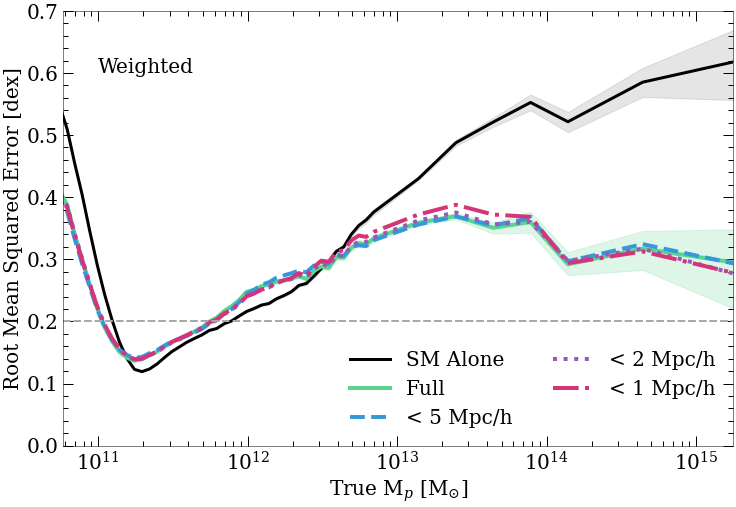

In [191]:
fig, ax = plot_errors(ylim)

ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')

labels = ['Full','< 5 Mpc/h','< 2 Mpc/h','< 1 Mpc/h','< 1000 km/s','< 500 km/s','< 250 km/s']
color_list = [colors[1],colors[2],colors[3],colors[4],colors[2],colors[3],colors[4]]

ls = ['solid','dashed','dotted','dashdot','dashed','dotted','dashdot']

for i in range(len(stats_w3)):
    if i == 0:
        stats_i = stats_w3[i]
        print(stats_i[0])
        ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=color_list[i])
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=color_list[i])
    
    if i in [1,2,3]:
        stats_i = stats_w3[i]
        print(stats_i[0])
        ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=color_list[i])

ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')

ax.annotate("Weighted",(1e11,0.6),fontsize=20)

ax.legend(frameon=False,loc=4,ncol=2)

plt.savefig("Figures/cyl_FI_w1.pdf")

0.19602117864634425
0.19643485371971917
0.19643478677109005
0.19773774647877038


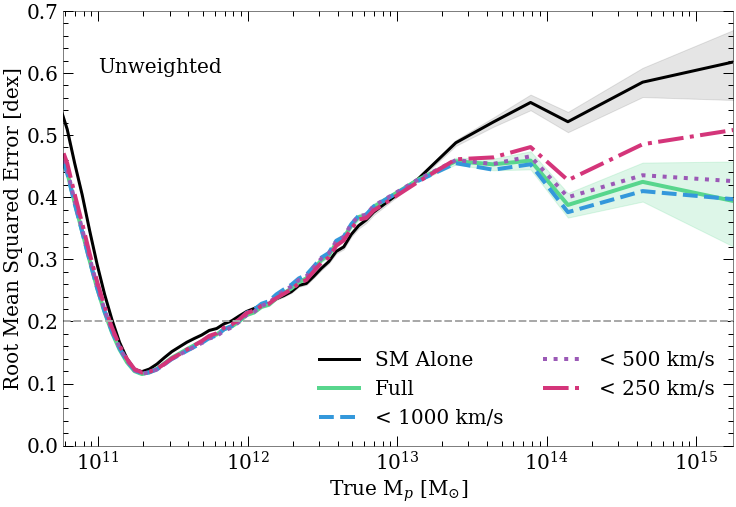

In [193]:
fig, ax = plot_errors(ylim)

ax.plot(pow(10,bin_centers)/h,SM_rmse,c='k',label='SM Alone',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers)/h,SM_low_res,SM_high_res,alpha=0.1,color='k')

labels = ['Full','< 5 Mpc/h','< 2 Mpc/h','< 1 Mpc/h','< 1000 km/s','< 500 km/s','< 250 km/s']
color_list = [colors[1],colors[2],colors[3],colors[4],colors[2],colors[3],colors[4]]

ls = ['solid','dashed','dotted','dashdot','dashed','dotted','dashdot']

for i in range(len(stats_u3)):
    if i == 0:
        stats_i = stats_u3[i]
        print(stats_i[0])
        ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=color_list[i])
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=color_list[i])
    
    if i in [4,5,6]:
        stats_i = stats_u3[i]
        print(stats_i[0])
        ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i],linestyle=ls[i],lw=4,c=color_list[i])
    

ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')

ax.annotate("Unweighted",(1e11,0.6),fontsize=20)

ax.legend(frameon=False,loc=4,ncol=2)

plt.savefig("Figures/cyl_FI_u2.pdf")

# Centrals Only Training

Same structure as default models from the first section except we only provide central halos for the training data

In [123]:
c_train = train[train['UPID']==-1]
c_val = val[val['UPID']==-1]

In [124]:
y_train_c = tf.convert_to_tensor(c_train['Halo_Mass'])
y_val_c = tf.convert_to_tensor(c_val['Halo_Mass'])

X_train_knn50_c = tf.convert_to_tensor(c_train[feature_list_knn50_v1])
X_val_knn50_c = tf.convert_to_tensor(c_val[feature_list_knn50_v1])
X_train_cyl_c = c_train[c_train.filter(like='Cylinder').columns]
X_train_cyl_c['Stellar Mass'] = c_train['Stellar_Mass(0)']

X_val_cyl_c = c_val[c_val.filter(like='Cylinder').columns]
X_val_cyl_c['Stellar Mass'] = c_val['Stellar_Mass(0)']

w_train_c = tf.convert_to_tensor(get_weights(c_train['Halo_Mass']))
w_val_c = tf.convert_to_tensor(get_weights(c_val['Halo_Mass']))

In [125]:
X_train_combo_c = c_train[combo_feature_list]
X_val_combo_c = c_val[combo_feature_list]

In [126]:
model_knn_u_cen,history_knn_u_cen = train_model("knn50_u_cen",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_c,X_val_knn50_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,0,128,
                                        epochs=50,patience=10)

model_cyl_u_cen,history_cyl_u_cen = train_model("cyl_u_cen",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_cyl_c,X_val_cyl_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,0,128,
                                        epochs=50,patience=10)

model_combo_u_cen,history_combo_u_cen = train_model("combo_u_cen",(133,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_combo_c,X_val_combo_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,0,128,
                                        epochs=50,patience=10)


model_knn_w_cen,history_knn_w_cen = train_model("knn50_w_cen",(101,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_knn50_c,X_val_knn50_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,1,128,
                                        epochs=50,patience=10)

model_cyl_w_cen,history_cyl_w_cen = train_model("cyl_w_cen",(33,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_cyl_c,X_val_cyl_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,1,128,
                                        epochs=50,patience=10)

model_combo_w_cen,history_combo_w_cen = train_model("combo_w_cen",(133,),n_layers,0.8,0.001,
                                        activation_fnc,loss_fnc,
                                        X_train_combo_c,X_val_combo_c,y_train_c,y_val_c,
                                        w_train_c,w_val_c,1,128,
                                        epochs=50,patience=10)

knn50_u_cen
Epoch 1/50
10442/10442 - 16s - loss: 0.2704 - mean_squared_error: 0.1299 - mean_absolute_error: 0.2704 - val_loss: 0.2595 - val_mean_squared_error: 0.1181 - val_mean_absolute_error: 0.2595 - 16s/epoch - 1ms/step
Epoch 2/50
10442/10442 - 15s - loss: 0.2601 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2601 - val_loss: 0.2562 - val_mean_squared_error: 0.1155 - val_mean_absolute_error: 0.2562 - 15s/epoch - 1ms/step
Epoch 3/50
10442/10442 - 15s - loss: 0.2580 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2580 - val_loss: 0.2566 - val_mean_squared_error: 0.1161 - val_mean_absolute_error: 0.2566 - 15s/epoch - 1ms/step
Epoch 4/50
10442/10442 - 15s - loss: 0.2570 - mean_squared_error: 0.1165 - mean_absolute_error: 0.2570 - val_loss: 0.2568 - val_mean_squared_error: 0.1167 - val_mean_absolute_error: 0.2568 - 15s/epoch - 1ms/step
Epoch 5/50
10442/10442 - 14s - loss: 0.2564 - mean_squared_error: 0.1158 - mean_absolute_error: 0.2564 - val_loss: 0.2597 - val_mean_squared

Epoch 3/50
10442/10442 - 6s - loss: 0.2663 - mean_squared_error: 0.1262 - mean_absolute_error: 0.2663 - val_loss: 0.2638 - val_mean_squared_error: 0.1238 - val_mean_absolute_error: 0.2638 - 6s/epoch - 618us/step
Epoch 4/50
10442/10442 - 7s - loss: 0.2658 - mean_squared_error: 0.1258 - mean_absolute_error: 0.2658 - val_loss: 0.2646 - val_mean_squared_error: 0.1239 - val_mean_absolute_error: 0.2646 - 7s/epoch - 678us/step
Epoch 5/50
10442/10442 - 8s - loss: 0.2656 - mean_squared_error: 0.1256 - mean_absolute_error: 0.2656 - val_loss: 0.2656 - val_mean_squared_error: 0.1260 - val_mean_absolute_error: 0.2656 - 8s/epoch - 721us/step
Epoch 6/50
10442/10442 - 7s - loss: 0.2654 - mean_squared_error: 0.1254 - mean_absolute_error: 0.2654 - val_loss: 0.2639 - val_mean_squared_error: 0.1239 - val_mean_absolute_error: 0.2639 - 7s/epoch - 677us/step
Epoch 7/50
10442/10442 - 7s - loss: 0.2652 - mean_squared_error: 0.1252 - mean_absolute_error: 0.2652 - val_loss: 0.2639 - val_mean_squared_error: 0.124

Epoch 15/50
10442/10442 - 18s - loss: 0.2513 - mean_squared_error: 0.1112 - mean_absolute_error: 0.2513 - val_loss: 0.2533 - val_mean_squared_error: 0.1132 - val_mean_absolute_error: 0.2533 - 18s/epoch - 2ms/step
Epoch 16/50
10442/10442 - 19s - loss: 0.2511 - mean_squared_error: 0.1109 - mean_absolute_error: 0.2511 - val_loss: 0.2537 - val_mean_squared_error: 0.1136 - val_mean_absolute_error: 0.2537 - 19s/epoch - 2ms/step
Epoch 17/50
10442/10442 - 19s - loss: 0.2511 - mean_squared_error: 0.1108 - mean_absolute_error: 0.2511 - val_loss: 0.2523 - val_mean_squared_error: 0.1119 - val_mean_absolute_error: 0.2523 - 19s/epoch - 2ms/step
Epoch 18/50
10442/10442 - 19s - loss: 0.2508 - mean_squared_error: 0.1107 - mean_absolute_error: 0.2508 - val_loss: 0.2523 - val_mean_squared_error: 0.1118 - val_mean_absolute_error: 0.2523 - 19s/epoch - 2ms/step
Epoch 19/50
10442/10442 - 18s - loss: 0.2507 - mean_squared_error: 0.1106 - mean_absolute_error: 0.2507 - val_loss: 0.2519 - val_mean_squared_error:

Epoch 15/50
10442/10442 - 15s - loss: 0.3794 - mean_squared_error: 0.1194 - mean_absolute_error: 0.2608 - weighted_mean_squared_error: 0.1591 - weighted_mean_absolute_error: 0.2980 - val_loss: 0.3840 - val_mean_squared_error: 0.1188 - val_mean_absolute_error: 0.2622 - val_weighted_mean_squared_error: 0.1639 - val_weighted_mean_absolute_error: 0.3017 - 15s/epoch - 1ms/step
Epoch 16/50
10442/10442 - 18s - loss: 0.3790 - mean_squared_error: 0.1192 - mean_absolute_error: 0.2606 - weighted_mean_squared_error: 0.1587 - weighted_mean_absolute_error: 0.2977 - val_loss: 0.3802 - val_mean_squared_error: 0.1186 - val_mean_absolute_error: 0.2599 - val_weighted_mean_squared_error: 0.1612 - val_weighted_mean_absolute_error: 0.2987 - 18s/epoch - 2ms/step
Epoch 17/50
10442/10442 - 16s - loss: 0.3786 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2605 - weighted_mean_squared_error: 0.1582 - weighted_mean_absolute_error: 0.2973 - val_loss: 0.3830 - val_mean_squared_error: 0.1226 - val_mean_absolu

Epoch 37/50
10442/10442 - 17s - loss: 0.3737 - mean_squared_error: 0.1175 - mean_absolute_error: 0.2590 - weighted_mean_squared_error: 0.1539 - weighted_mean_absolute_error: 0.2935 - val_loss: 0.3841 - val_mean_squared_error: 0.1178 - val_mean_absolute_error: 0.2596 - val_weighted_mean_squared_error: 0.1670 - val_weighted_mean_absolute_error: 0.3017 - 17s/epoch - 2ms/step
Epoch 38/50
10442/10442 - 16s - loss: 0.3731 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2589 - weighted_mean_squared_error: 0.1534 - weighted_mean_absolute_error: 0.2930 - val_loss: 0.3868 - val_mean_squared_error: 0.1267 - val_mean_absolute_error: 0.2697 - val_weighted_mean_squared_error: 0.1670 - val_weighted_mean_absolute_error: 0.3039 - 16s/epoch - 2ms/step
Epoch 39/50
10442/10442 - 17s - loss: 0.3729 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2589 - weighted_mean_squared_error: 0.1530 - weighted_mean_absolute_error: 0.2928 - val_loss: 0.3795 - val_mean_squared_error: 0.1189 - val_mean_absolu

Epoch 20/50
10442/10442 - 8s - loss: 0.3946 - mean_squared_error: 0.1304 - mean_absolute_error: 0.2712 - weighted_mean_squared_error: 0.1739 - weighted_mean_absolute_error: 0.3099 - val_loss: 0.3954 - val_mean_squared_error: 0.1322 - val_mean_absolute_error: 0.2728 - val_weighted_mean_squared_error: 0.1753 - val_weighted_mean_absolute_error: 0.3106 - 8s/epoch - 783us/step
Epoch 21/50
10442/10442 - 8s - loss: 0.3945 - mean_squared_error: 0.1305 - mean_absolute_error: 0.2713 - weighted_mean_squared_error: 0.1735 - weighted_mean_absolute_error: 0.3098 - val_loss: 0.3943 - val_mean_squared_error: 0.1301 - val_mean_absolute_error: 0.2705 - val_weighted_mean_squared_error: 0.1746 - val_weighted_mean_absolute_error: 0.3098 - 8s/epoch - 739us/step
Epoch 22/50
10442/10442 - 7s - loss: 0.3941 - mean_squared_error: 0.1303 - mean_absolute_error: 0.2712 - weighted_mean_squared_error: 0.1735 - weighted_mean_absolute_error: 0.3095 - val_loss: 0.3939 - val_mean_squared_error: 0.1266 - val_mean_absolut

Epoch 7/50
10442/10442 - 19s - loss: 0.3792 - mean_squared_error: 0.1194 - mean_absolute_error: 0.2610 - weighted_mean_squared_error: 0.1588 - weighted_mean_absolute_error: 0.2978 - val_loss: 0.3960 - val_mean_squared_error: 0.1202 - val_mean_absolute_error: 0.2624 - val_weighted_mean_squared_error: 0.1719 - val_weighted_mean_absolute_error: 0.3111 - 19s/epoch - 2ms/step
Epoch 8/50
10442/10442 - 21s - loss: 0.3781 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2607 - weighted_mean_squared_error: 0.1577 - weighted_mean_absolute_error: 0.2969 - val_loss: 0.3764 - val_mean_squared_error: 0.1158 - val_mean_absolute_error: 0.2580 - val_weighted_mean_squared_error: 0.1570 - val_weighted_mean_absolute_error: 0.2957 - 21s/epoch - 2ms/step
Epoch 9/50
10442/10442 - 20s - loss: 0.3768 - mean_squared_error: 0.1186 - mean_absolute_error: 0.2603 - weighted_mean_squared_error: 0.1562 - weighted_mean_absolute_error: 0.2959 - val_loss: 0.3786 - val_mean_squared_error: 0.1186 - val_mean_absolute_

In [36]:
#Uncomment lines below to load pre-trained models

#model_knn_u_cen = tf.keras.models.load_model('Models/run_6_5/net_knn50_u_cen_trained.h5')
#model_knn_w_cen = tf.keras.models.load_model('Models/run_6_5/net_knn50_w_cen_trained.h5')
#model_cyl_u_cen = tf.keras.models.load_model('Models/run_6_5/net_cyl_u_cen_trained.h5')
#model_cyl_w_cen = tf.keras.models.load_model('Models/run_6_5/net_cyl_w_cen_trained.h5')
#model_combo_u_cen = tf.keras.models.load_model('Models/run_6_5/net_combo_u_cen_trained.h5')
#model_combo_w_cen = tf.keras.models.load_model('Models/run_6_5/net_combo_w_cen_trained.h5')

In [41]:
X_test_knn50_c = tf.convert_to_tensor(centrals_test[feature_list_knn50_v1])
X_test_cyl_c = centrals_test[centrals_test.filter(like='Cylinder').columns]
X_test_cyl_c['Stellar Mass'] = centrals_test['Stellar_Mass(0)']
X_test_combo_c = tf.convert_to_tensor(centrals_test[combo_feature_list])
y_true_cen = pd.Series(scaler1t.inverse_transform(centrals_test['Halo_Mass']))

In [42]:
models_u4 = [model_knn_u_cen,model_cyl_u_cen,model_combo_u_cen]
models_w4 = [model_knn_w_cen,model_cyl_w_cen,model_combo_w_cen]
features4 = [X_test_knn50_c,X_test_cyl_c,X_test_combo_c]
outputs_u4 = []
outputs_w4 = []
stats_u4 = []
stats_w4 = []

bins_new = np.append(np.arange(10.5,12.75,0.05),[13,13.25,13.5,13.75,14,14.5,15.25])
bin_centers_new = get_bin_centers(bins_new)

for i in range(len(models_u4)):
    output_u4, stats_u4_ind = get_stats_indiv(models_u4[i],features4[i],y_true_cen,bins_new)
    outputs_u4.append(output_u4)
    stats_u4.append(stats_u4_ind)
    
    output_w4, stats_w4_ind = get_stats_indiv(models_w4[i],features4[i],y_true_cen,bins_new)
    outputs_w4.append(output_w4)
    stats_w4.append(stats_w4_ind)

14740/14740 [==============================] - 5s 363us/step


0.16398016513899621
0.16791321056359532
0.17049278791971917
0.17482179150050664
0.16273922399078253
0.16676419288681193


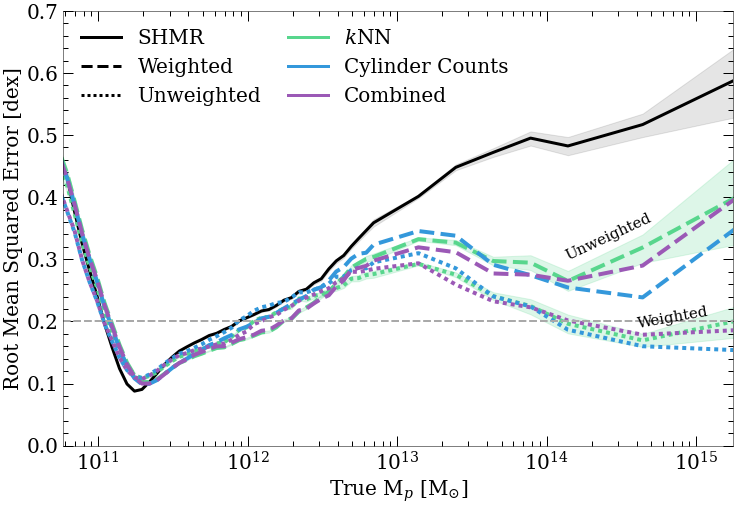

In [195]:
ylim=0.7
fig, ax = plot_errors(ylim)


ax.plot(pow(10,bin_centers)/h,rmse_cen,c='k',label='SM Alone',linestyle='solid',lw=3)
ax.fill_between(pow(10,bin_centers)/h,low_res_cen,high_res_cen,alpha=0.1,color='k')

labels = ['$k$NN(50)','Cylinder','Combo']

for i in range(len(features4)):
    stats_i = stats_u4[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i]+' Weighted',linestyle='dashed',lw=4,c=colors[i+1])
    if i == 0:
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])
    
    stats_i = stats_w4[i]
    print(stats_i[0])
    ax.plot(pow(10,bin_centers)/h,stats_i[1],label=labels[i]+' Weighted',linestyle=(0,(1,1)),lw=4,c=colors[i+1])
    if i == 0:
        ax.fill_between(pow(10,bin_centers)/h,stats_i[2],stats_i[3],alpha=0.2,color=colors[i+1])

ax.axhline(0.2,color='#A9A9A9',lw=2,ls='dashed')


handles1 = [mpl.lines.Line2D([],[],color='black',ls='solid',label=r'SHMR',lw=3),
           mpl.lines.Line2D([],[],color='black',ls='dashed',label=r'Weighted',lw=3),
           mpl.lines.Line2D([],[],color='black',ls=(0,(1,1)),label=r'Unweighted',lw=3)]
first_legend = ax.legend(handles=handles1,frameon=False)
ax.add_artist(first_legend)

handles2 = [mpl.lines.Line2D([],[],color=colors[1],ls='solid',label=r'$k$NN',lw=3),
           mpl.lines.Line2D([],[],color=colors[2],ls='solid',label=r'Cylinder Counts',lw=3),
           mpl.lines.Line2D([],[],color=colors[3],ls='solid',label=r'Combined',lw=3)]
ax.legend(handles=handles2,loc='upper center',frameon=False)

ax.annotate("Unweighted",(1.3e14,0.3),rotation=25,fontsize=15)
ax.annotate("Weighted",(4e14,0.19),rotation=10,fontsize=15)

plt.savefig("Figures/Centrals_Only_loss.pdf")